In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
import seaborn as sns

from nilearn import plotting
from nilearn.image import new_img_like

In [2]:
import rsatoolbox
from rsatoolbox.inference import eval_fixed
from rsatoolbox.model import ModelFixed, Model
from rsatoolbox.rdm import RDMs
from rsatoolbox.vis import show_rdm, show_rdm_panel

from rsatoolbox.util.searchlight import get_volume_searchlight, get_searchlight_RDMs, evaluate_models_searchlight
from glob import glob

In [3]:
def upper_tri(RDM):
    """upper_tri returns the upper triangular index of an RDM

    Args:
        RDM 2Darray: squareform RDM

    Returns:
        1D array: upper triangular vector of the RDM
    """
    # returns the upper triangle
    m = RDM.shape[0]
    r, c = np.triu_indices(m, 1)
    return RDM[r, c]

In [45]:
project_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 'FLT/')
fmriprep_dir = os.path.join(project_dir, 'derivatives', '22.1.1') # 'fmriprep_noSDC')

bidsroot = os.path.join(project_dir, 'data_bids') #'archive', 'data_bids_noIntendedFor')
deriv_dir = os.path.join(bidsroot, 'derivatives')

fwhm_sub = 3.0
model_dir = os.path.join(deriv_dir, 'nilearn', 'level-1_fwhm-{:.02f}'.format(fwhm_sub,))

task_list = ['stgrid']
space_label = 'MNI152NLin2009cAsym'

In [67]:
'''
project_dir = os.path.join('/Users/KRS228/',
                         'OneDrive - University of Pittsburgh/7T',)
model_dir = os.path.join(project_dir,
                         'task-stgrid')
fwhm_sub = 3.0
task_list = ['stgrid']
space_label = 'MNI152NLin2009cAsym'
'''

In [5]:
model_dir

'/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-3.00'

In [6]:
all_participant_list = [os.path.basename(x).split('_')[0] for x in sorted(glob(os.path.abspath(model_dir) + '/*'))]

## Make models

### Stimulus RDMs

In [7]:
from scipy.spatial.distance import pdist, squareform


In [9]:
stim_mod_fpath = os.path.join(project_dir, 
                              'sourcedata', 
                              '2022-2-8_Grid.txt')
mod_df = pd.read_csv(stim_mod_fpath, sep='\t', header=None)

mod_df.columns = ['temp_mod_rate', 'spect_mod_rate']
mod_df.index += 1 # 1-index

In [10]:
pattern_descriptors = mod_df.to_dict()

In [11]:
mod_df

temp_mod_rate  spect_mod_rate
1        1.600000            0.16
2        6.066667            0.16
3       10.533333            0.16
4       15.000000            0.16
5        1.600000            0.94
6        6.066667            0.94
7       10.533333            0.94
8       15.000000            0.94
9        1.600000            1.72
10       6.066667            1.72
11      10.533333            1.72
12      15.000000            1.72
13       1.600000            2.50
14       6.066667            2.50
15      10.533333            2.50
16      15.000000            2.50

In [12]:
mod_df.to_numpy().shape

(16, 2)

In [13]:
temp_array = mod_df.temp_mod_rate.to_numpy()
spec_array = mod_df.spect_mod_rate.to_numpy()

In [14]:
def z_transform(X):
    z = (X - X.mean()) / X.std()
    return z

In [15]:
spectemp_array = np.vstack(([z_transform(spec_array)], [z_transform(temp_array)]))

In [16]:
spectemp_array

array([[-1.34164079, -1.34164079, -1.34164079, -1.34164079, -0.4472136 ,
        -0.4472136 , -0.4472136 , -0.4472136 ,  0.4472136 ,  0.4472136 ,
         0.4472136 ,  0.4472136 ,  1.34164079,  1.34164079,  1.34164079,
         1.34164079],
       [-1.34164079, -0.4472136 ,  0.4472136 ,  1.34164079, -1.34164079,
        -0.4472136 ,  0.4472136 ,  1.34164079, -1.34164079, -0.4472136 ,
         0.4472136 ,  1.34164079, -1.34164079, -0.4472136 ,  0.4472136 ,
         1.34164079]])

In [17]:
spectemp_array = spectemp_array.reshape(16,2)

In [18]:
spectemp_dist = squareform(pdist(spectemp_array))

In [19]:
spectemp_dist.shape

(16, 16)

In [20]:
# calculate the absolute difference between elements of a 1-D array
def array_dist(array_1d):
    array_dist = np.zeros((len(array_1d), len(array_1d)))
    for rx, pval in enumerate(array_1d):
        for cx, cval in enumerate(array_1d):
            array_dist[rx, cx] = abs(pval-cval)
    return array_dist

In [21]:
temp_dist = array_dist(temp_array)
spec_dist = array_dist(spec_array)

In [22]:
temp_dist.shape

(16, 16)

In [23]:
stim_rdms_name_list = ['spectrotemporal_mod_rate', 'spectral_mod_rate', 'temporal_mod_rate']
#stim_rdms_array = np.dstack((spectemp_dist, spec_dist, temp_dist))
stim_rdms_array = np.array([spectemp_dist, spec_dist, temp_dist])


In [24]:
stim_rdms_array.shape

(3, 16, 16)

In [25]:
stim_rdms = RDMs(stim_rdms_array,
                  rdm_descriptors={'stimulus_model':stim_rdms_name_list,},
                  #pattern_descriptors=pattern_descriptors,
                  dissimilarity_measure='Euclidean'
                  )

In [26]:
stim_rdms

rsatoolbox.rdm.RDMs(
dissimilarity_measure = 
Euclidean
dissimilarities = 
[[ 0.          1.26491106  1.26491106  2.52982213  2.52982213  3.79473319
   3.79473319  0.89442719  3.2249031   0.89442719  3.2249031   0.89442719
   3.2249031   0.89442719  3.2249031   1.26491106  1.26491106  2.52982213
   2.52982213  3.79473319  3.79473319  0.89442719  3.2249031   0.89442719
   3.2249031   0.89442719  3.2249031   0.89442719  3.2249031   0.
   1.26491106  1.26491106  2.52982213  2.52982213  0.89442719  2.
   0.89442719  2.          0.89442719  2.          0.89442719  2.
   1.26491106  1.26491106  2.52982213  2.52982213  0.89442719  2.
   0.89442719  2.          0.89442719  2.          0.89442719  2.
   0.          1.26491106  1.26491106  2.          0.89442719  2.
   0.89442719  2.          0.89442719  2.          0.89442719  1.26491106
   1.26491106  2.          0.89442719  2.          0.89442719  2.
   0.89442719  2.          0.89442719  0.          3.2249031   0.89442719
   3.2249031   0.89

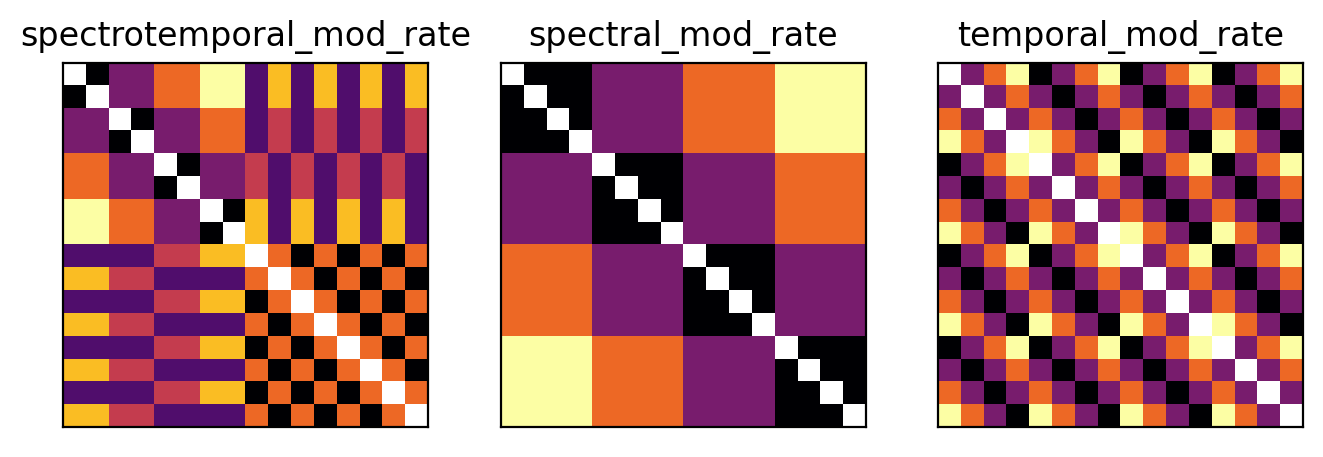

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(8,4), dpi=200)
for dx, descrip in enumerate(stim_rdms.rdm_descriptors['stimulus_model']):
    spec_rdms = stim_rdms.subset('stimulus_model', descrip)
    show_rdm_panel(spec_rdms, ax=axs.flat[dx], rdm_descriptor='stimulus_model', cmap='inferno',)


#### Convert to models

In [28]:
stim_models = []
for dx, descrip in enumerate(stim_rdms.rdm_descriptors['stimulus_model']):
    spec_model = ModelFixed( '{} RDM'.format(descrip), stim_rdms.subset('stimulus_model', descrip))
    stim_models.append(spec_model)

In [29]:
stim_models

# ROI-based RSA

In [32]:
mask_list = [#'mask-L-CN', 'mask-L-SOC', 
             'mask-L-IC', 'mask-L-MGN', 
             'mask-L-HG', 'mask-L-PP', 'mask-L-PT', 
             'mask-L-STGp', 'mask-L-STGa', 
             #'mask-R-CN', 'mask-R-SOC', 
             'mask-R-IC', 'mask-R-MGN', 
             'mask-R-HG', 'mask-R-PP', 'mask-R-PT', 
             'mask-R-STGp', 'mask-R-STGa']

### CRC

In [33]:
participants_fpath = os.path.join(bidsroot, 'participants.tsv')
participants_df = pd.read_csv(participants_fpath, sep='\t')

# subjects to ignore (not fully processed, etc.)
ignore_subs = ['sub-FLT01', 'sub-FLT16',
               'sub-FLT19', 'sub-FLT20', 
               'sub-FLT25', 'sub-FLT26', 
              ]
participants_df.drop(participants_df[participants_df.participant_id.isin(ignore_subs)].index,
                     inplace=True)

# re-sort by participant ID
participants_df.sort_values(by=['participant_id'], 
                            ignore_index=True, 
                            inplace=True)

In [34]:
participants_df

participant_id  age sex         group  FFR_id
0       sub-FLT02   21   F  non-Mandarin  1002.0
1       sub-FLT03   25   F      Mandarin  2002.0
2       sub-FLT04   21   F  non-Mandarin  1003.0
3       sub-FLT05   26   M      Mandarin  3010.0
4       sub-FLT06   21   F  non-Mandarin  3001.0
5       sub-FLT07   22   M      Mandarin  2003.0
6       sub-FLT08   23   F      Mandarin  2005.0
7       sub-FLT09   30   F  non-Mandarin  3002.0
8       sub-FLT10   23   F      Mandarin  2006.0
9       sub-FLT11   20   F  non-Mandarin  1005.0
10      sub-FLT12   20   F  non-Mandarin  3004.0
11      sub-FLT13   23   F  non-Mandarin  3005.0
12      sub-FLT14   23   M  non-Mandarin  3006.0
13      sub-FLT15   22   M      Mandarin  2010.0
14      sub-FLT17   29   F      Mandarin     NaN
15      sub-FLT18   24   M      Mandarin  2016.0
16      sub-FLT21   21   M      Mandarin  2011.0
17      sub-FLT22   41   F      Mandarin  2017.0
18      sub-FLT23   26   F      Mandarin  2013.0
19      sub-FLT24   20   M      Mandarin  2015.0
20      sub-FLT27   22   F  non-Mandarin     NaN
21      sub-FLT30   25   M       control     NaN

In [35]:
# create group-specific lists of subject IDs
sub_group_dict = {'Mandarin': list(participants_df.participant_id[participants_df.group=='Mandarin']),
                  'non-Mandarin': list(participants_df.participant_id[participants_df.group=='non-Mandarin'])}

In [36]:
len(sub_group_dict['Mandarin'])

12

In [38]:
participant_list = participants_df.participant_id
participant_list = [p.split('-')[1] for p in participant_list]
group_assignment = participants_df.group

## Run-specific

In [71]:
group_rdm_list = []
for sx, sub_id in enumerate(participant_list):
    print(sub_id)
    group_id = group_assignment[sx]

    # set this path to wherever you saved the folder containing the img-files
    model_folder = os.path.join(model_dir, 'masked_statmaps',
                               'sub-{}'.format(sub_id),
                               'statmaps_masked',
                               'stimulus_per_run')
    for runx, data_folder in enumerate(sorted(glob('{}/run*'.format(model_folder)))):
        #print(data_folder)
        
        #mask_list = np.unique([os.path.basename(x).split('_')[2] for x in all_im_paths])

        all_mask_data = []
        for mx, mask_descrip in enumerate(mask_list):

            #print(mask_descrip)
            image_paths = sorted(glob('{}/{}/*_cond-*_map-beta.csv'.format(data_folder, mask_descrip)))

            mask_fpath = os.path.join(deriv_dir, 'nilearn', 'masks', 'sub-{}'.format(sub_id),
                                      'space-{}'.format(space_label), 'masks-dseg',
                                      'sub-{}_space-{}_mask-gm.nii.gz'.format(sub_id, space_label))

            try:
                n_vox = np.genfromtxt(image_paths[0]).shape[0]
            except IndexError:
                n_vox = 1

            data = np.zeros((len(image_paths), n_vox))
            for x, im in enumerate(image_paths):
                data[x] = np.genfromtxt(im)
            all_mask_data.append(data)

            roi_rdms = []
        for rx, mask_data in enumerate(all_mask_data):
            dataset = rsatoolbox.data.Dataset(mask_data, 
                                              descriptors={'participant': sub_id, 
                                                           'run': os.path.basename(data_folder),
                                                           'ROI': mask_list[rx], 
                                                           'group': group_id
                                                          },)
            test_rdm = rsatoolbox.rdm.calc_rdm(dataset)
            roi_rdms.append(test_rdm)
            group_rdm_list.append(test_rdm)

        concat_rdms = rsatoolbox.rdm.rdms.concat(roi_rdms)
group_rdms = rsatoolbox.rdm.rdms.concat(group_rdm_list)

sub-FLT02


NameError: name 'group_assignment' is not defined

In [87]:
group_rdms.pattern_descriptors = pattern_descriptors

In [88]:
np.save('group_run_rdms', group_rdms, allow_pickle=True)

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [65]:
group_rdms = np.load('group_run_rdms.npy', allow_pickle=True)

In [89]:
group_rdms

rsatoolbox.rdm.RDMs(
dissimilarity_measure = 
None
dissimilarities = 
[[1536.46656687 1749.28533822  809.14152673 ...  623.87707323
  1374.79894782 1987.92105243]
 [3350.90486843 1780.37153689 2548.96189313 ...  700.2064735
  2411.57238106 1722.33756965]
 [1458.39589101  838.95106248 1010.83239691 ...  872.29990815
  1118.01960907 1058.91544171]
 ...
 [1083.96758711 1027.42530057 1079.58558813 ... 1093.14391343
  1106.60864433 1344.09983997]
 [1210.33166584  930.05495541 1007.45025593 ... 1042.56889395
  1249.12992311 1133.80725121]
 [1119.11971623 1337.01672692 1429.65596858 ... 1137.83931335
   965.93651404 1088.94174971]]
descriptors = 
{}
rdm_descriptors = 
{'participant': ['FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02'

In [101]:
mean_rdms_mand_list = []
mean_rdms_nman_list = []
for runx, run in enumerate(np.unique(group_rdms.rdm_descriptors['run'])):
    for rx, roi in enumerate(mask_list):
        # Mandarin-speaking
        dissim_mand = group_rdms.subset('group', value='Mandarin').subset('run', value=run).subset('ROI', value=roi).dissimilarities

        roi_mand = RDMs(dissim_mand.mean(axis=0),
                        rdm_descriptors={'run': run, 'ROI': mask_list[rx], 'group': 'Mandarin'},
                        pattern_descriptors=pattern_descriptors)
        mean_rdms_mand_list.append(roi_mand)

        # non-Mandarin-speaking
        dissim_nman = group_rdms.subset('group', value='non-Mandarin').subset('run', value=run).subset('ROI', value=roi).dissimilarities
        roi_nman = RDMs(dissim_nman.mean(axis=0),
                        rdm_descriptors={'run': run, 'ROI': mask_list[rx], 'group': 'non-Mandarin'},
                        pattern_descriptors=pattern_descriptors)
        mean_rdms_nman_list.append(roi_nman)

mean_rdms_mand = rsatoolbox.rdm.rdms.concat(mean_rdms_mand_list)
mean_rdms_nman = rsatoolbox.rdm.rdms.concat(mean_rdms_nman_list)



In [102]:
roi_nman

rsatoolbox.rdm.RDMs(
dissimilarity_measure = 
None
dissimilarities = 
[[ 1720.24063129  1720.34272514  1441.3127721   3509.45244581
   3590.17647989 20119.46535274  2537.09950716  2765.58285075
   2975.6078739   2313.80429068  3243.57996593  2185.63037562
   2149.08516846  1992.01590549  1730.54024121  1898.99983143
   1666.61974606  3215.4078944   3101.287001   17296.77542613
   2597.35755334  2588.96647854  2936.13381402  2942.7761211
   3469.30521401  3058.31280393  2585.3409436   2357.19210347
   2041.11450185  1806.45191746  3223.16025331  3114.21402891
  17165.11401434  2377.28241011  2577.90504183  2741.4864684
   2603.57684464  3067.23797149  2480.42770741  2429.68975542
   2057.16375908  2034.35376004  2840.83005577  2646.11046221
  16821.47068853  2354.19486764  2058.95085135  2251.23562537
   2174.67622932  2775.88349085  1628.91395525  2127.12524305
   2380.27208132  1813.37861704  1965.48407725 11322.3696644
   1741.08410442  2560.49710947  3385.59650876  3601.04496621
   

In [103]:
len(dissim_nman.mean(axis=0))

120

In [104]:
len(mean_rdms_nman_list)

108

In [105]:
len(mean_rdms_nman)

108

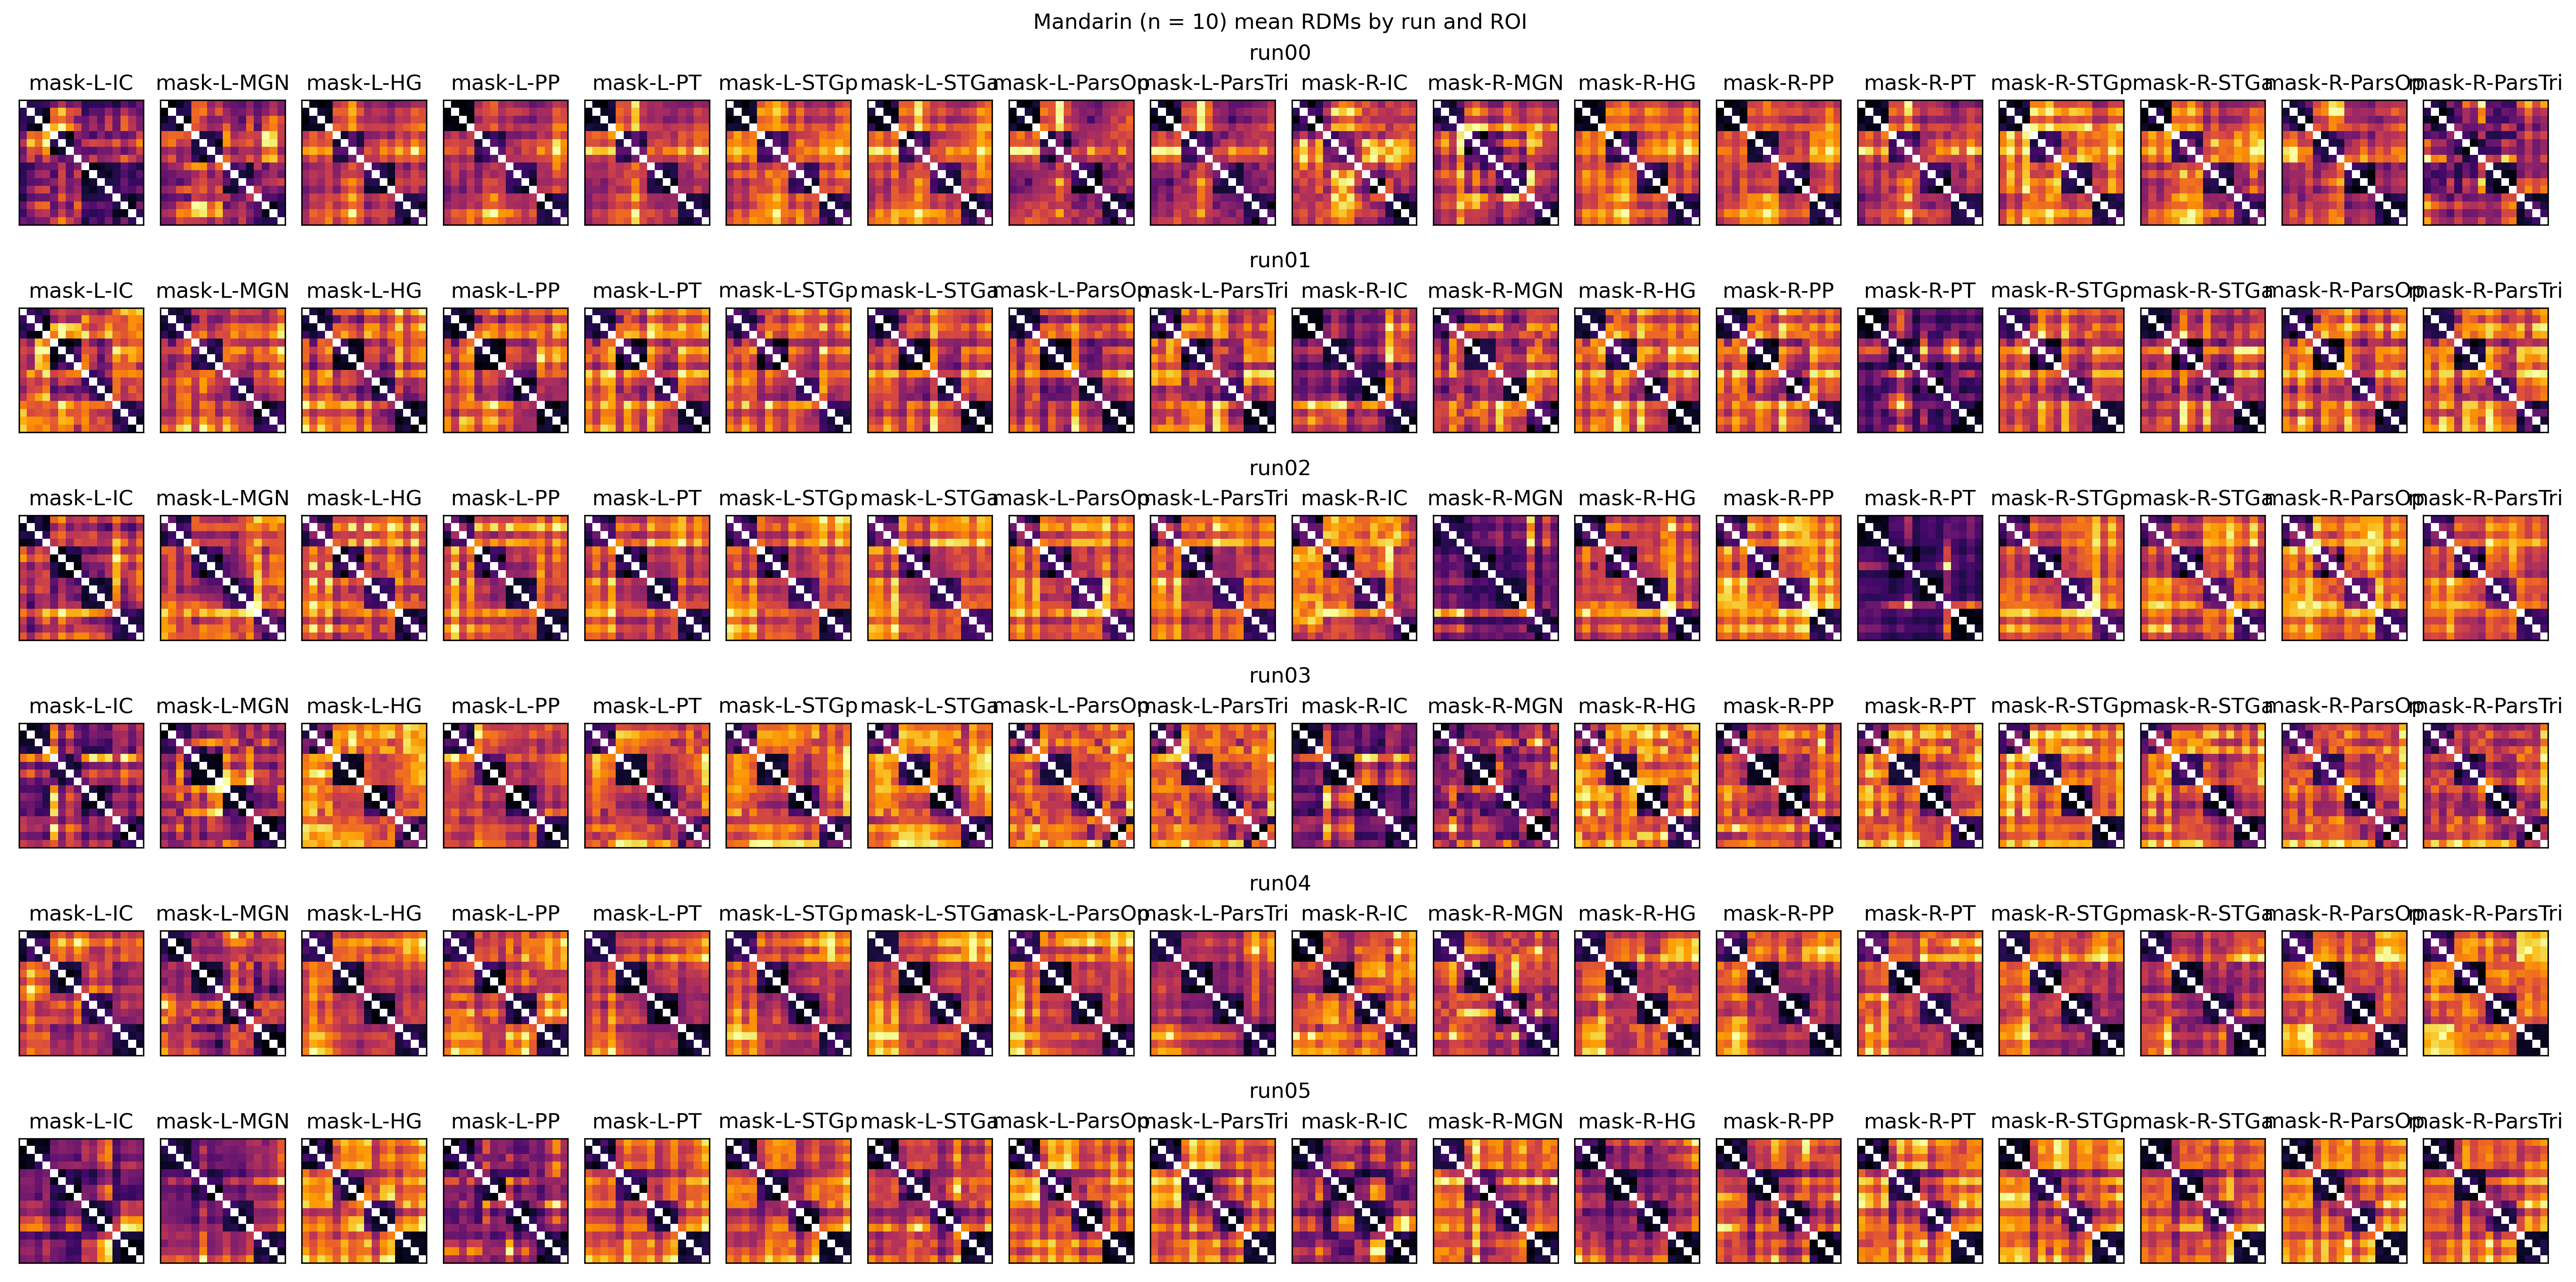

In [111]:
n_mand = len(sub_group_dict['Mandarin'])

fig = plt.figure(constrained_layout=True, figsize=(20,10), dpi=300)
fig.suptitle('Mandarin (n = {}) mean RDMs by run and ROI'.format(n_mand))

subfigs = fig.subfigures(nrows=6, ncols=1)


for sf, run in enumerate(np.unique(group_rdms.rdm_descriptors['run'])):
    subfigs[sf].suptitle(run)

    axs = subfigs[sf].subplots(nrows=1, ncols=len(mask_list))
    for rx, roi in enumerate(mask_list):
        rsatoolbox.vis.show_rdm_panel(mean_rdms_mand.subset('run', value=run).subset('ROI', value=roi), 
                                      rdm_descriptor='ROI', 
                                      cmap='inferno', 
                                      ax=axs[rx])

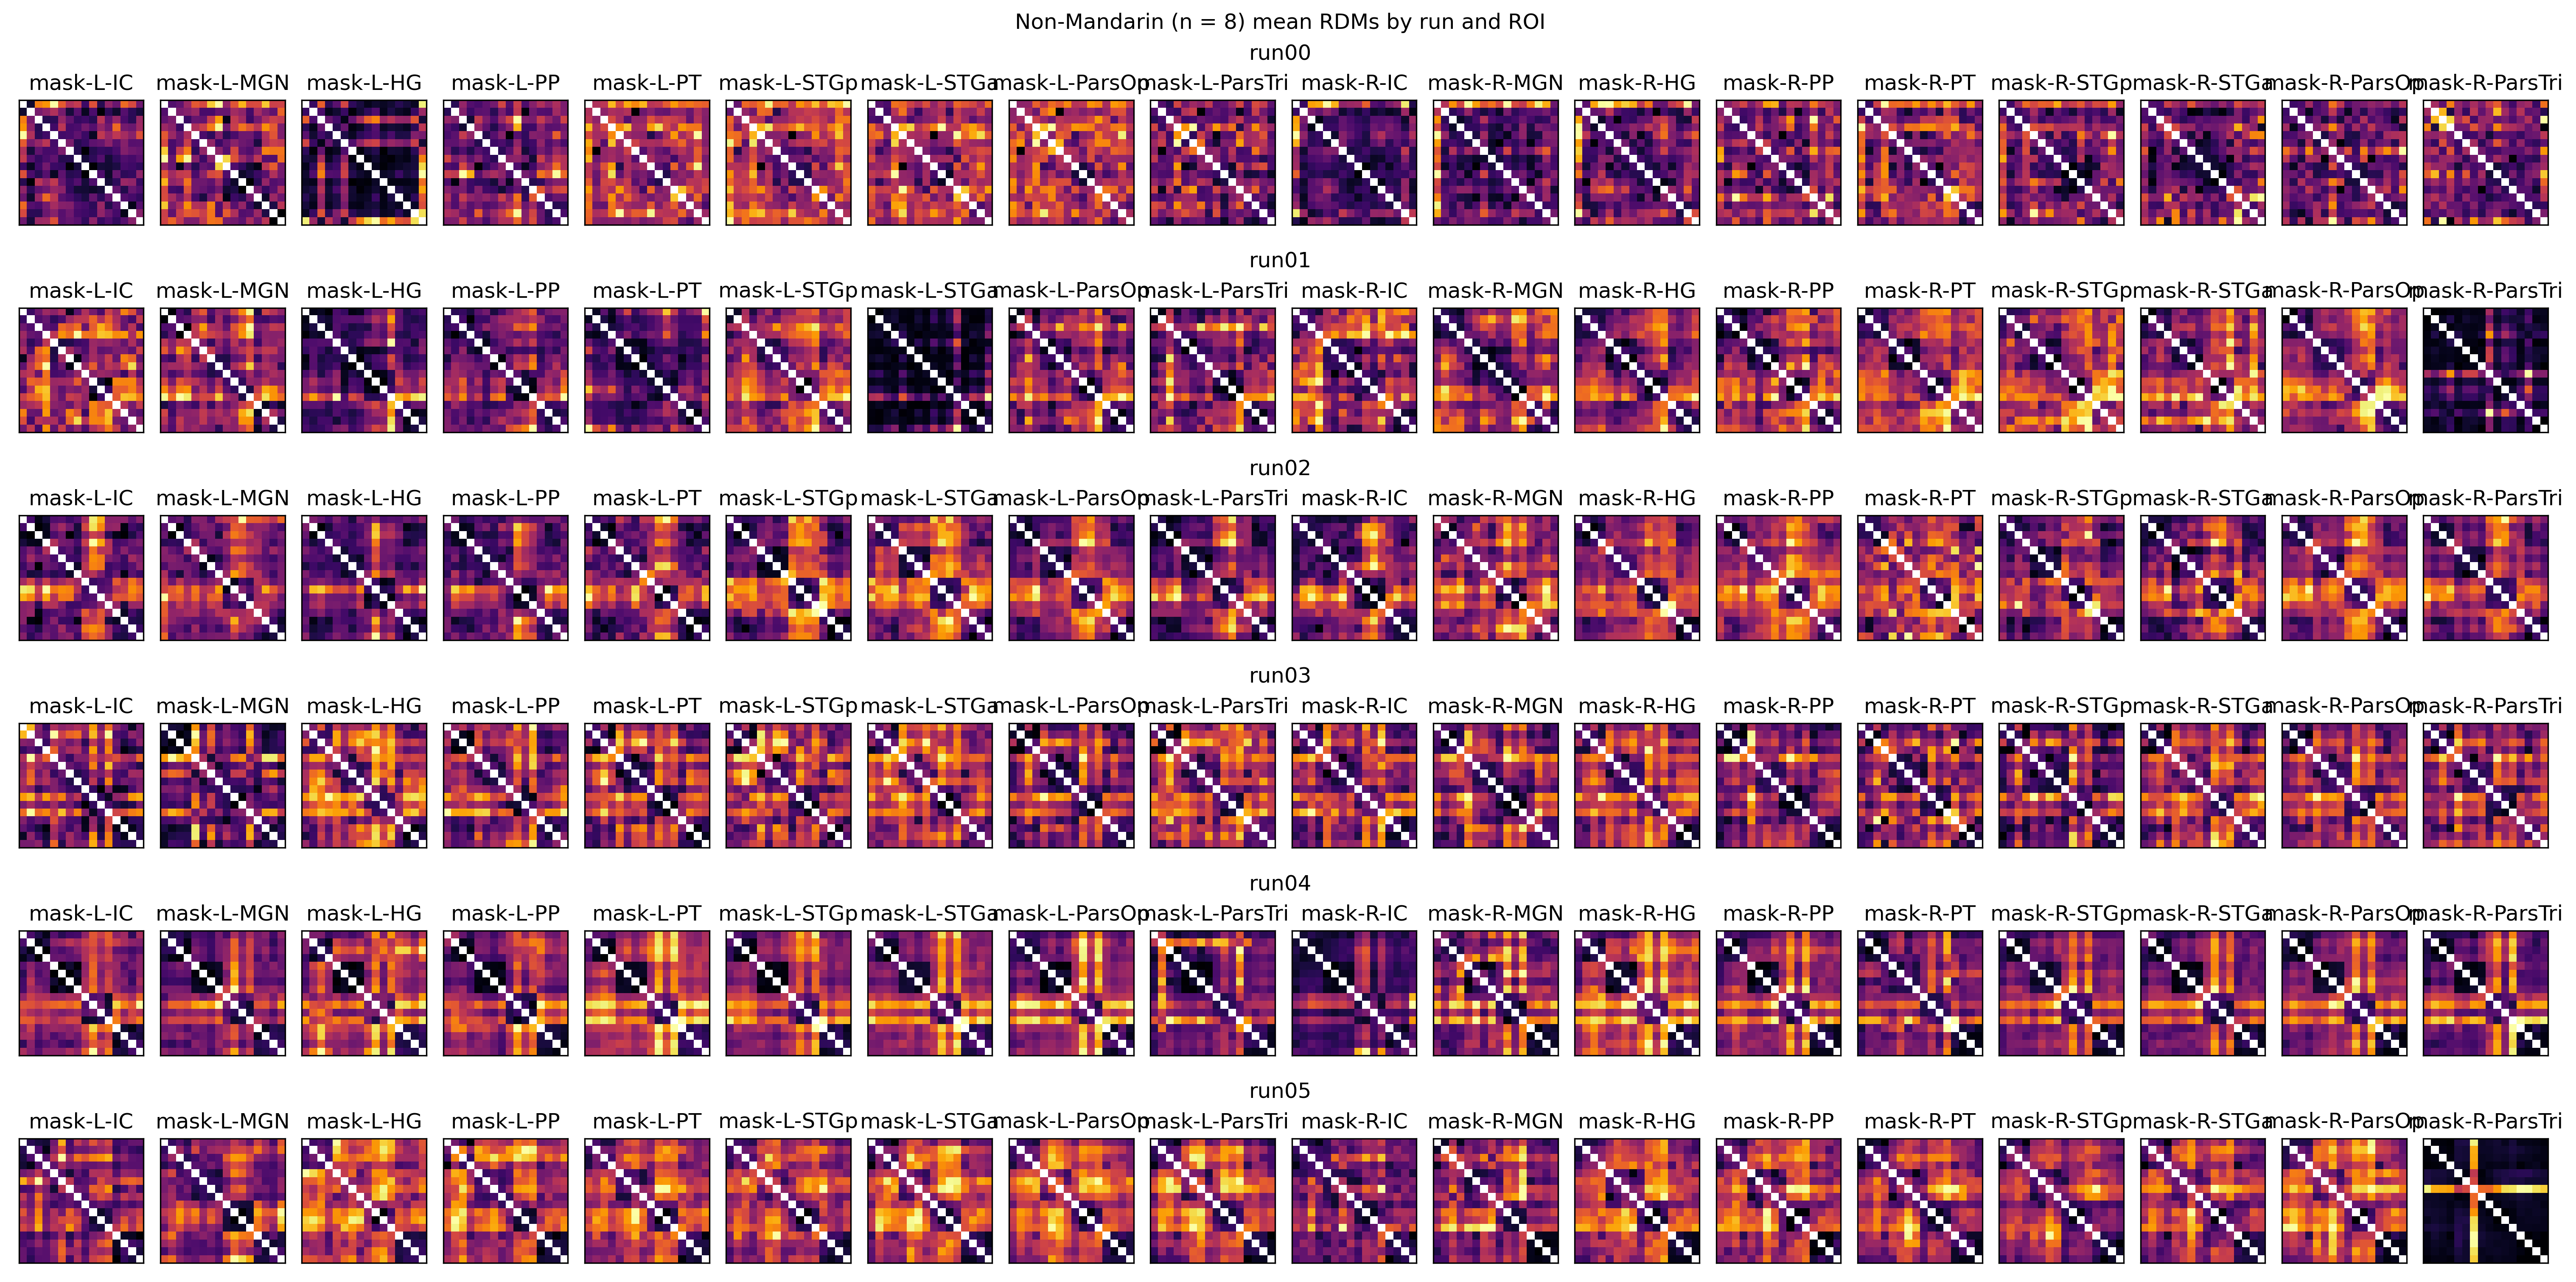

In [110]:
n_nman = len(sub_group_dict['non-Mandarin'])

fig = plt.figure(constrained_layout=True, figsize=(20,10), dpi=300)
fig.suptitle('Non-Mandarin (n = {}) mean RDMs by run and ROI'.format(n_nman))

subfigs = fig.subfigures(nrows=6, ncols=1)

for sf, run in enumerate(np.unique(group_rdms.rdm_descriptors['run'])):
    subfigs[sf].suptitle(run)

    axs = subfigs[sf].subplots(nrows=1, ncols=len(mask_list))
    for rx, roi in enumerate(mask_list):
        rsatoolbox.vis.show_rdm_panel(mean_rdms_nman.subset('run', value=run).subset('ROI', value=roi), 
                                      rdm_descriptor='ROI', 
                                      cmap='inferno', 
                                      ax=axs[rx])

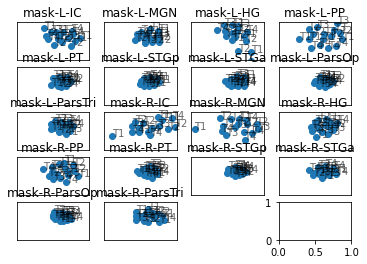

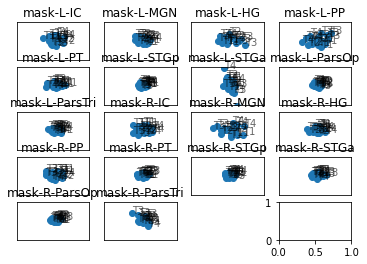

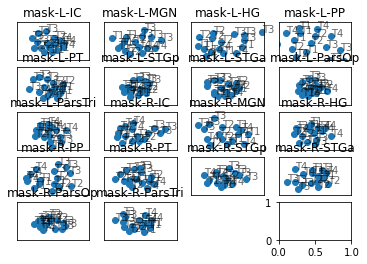

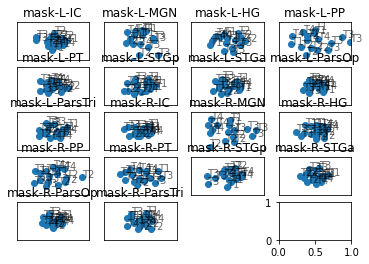

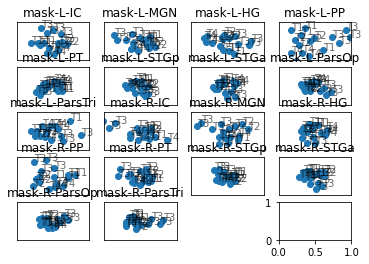

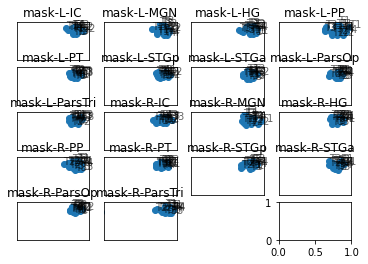

In [113]:
for sf, run in enumerate(np.unique(group_rdms.rdm_descriptors['run'])):
    rsatoolbox.vis.scatter_plot.show_MDS(mean_rdms_nman.subset('run', run), 
                                         rdm_descriptor='ROI',
                                         pattern_descriptor='tone');

## Run-specific RSA

## Run-all

In [135]:
'''
participant_list = ['sub-FLT02',
                    'sub-FLT03',
                    'sub-FLT05',
                    'sub-FLT06',
                    'sub-FLT07',
                    'sub-FLT08',
                    'sub-FLT10',]
''' 

In [49]:
glob(data_folder)

[]

In [46]:
group_rdm_list = []
for sx, sub_id in enumerate(participant_list):
    print(sub_id)
    # set this path to wherever you saved the folder containing the img-files
    data_folder = os.path.join(model_dir, 'masked_statmaps',
                               '{}'.format(sub_id),
                               'statmaps_masked',
                               'run-all')
    masked_data_dir = os.path.join(project_dir,
                           'task-stgrid_masked',
                           'level-1_fwhm-%.02f'%fwhm_sub,
                           'masked_statmaps',
                           sub_id, 'statmaps_masked', 'run-all')

    all_im_paths = sorted(glob('{}/*mask-*_cond-*_map-tstat.csv'.format(masked_data_dir)))
    #mask_list = np.unique([os.path.basename(x).split('_')[2] for x in all_im_paths])

    all_mask_data = []
    for mx, mask_descrip in enumerate(mask_list):

        #print(mask_descrip)
        image_paths = sorted(glob('{}/*{}_cond-*_map-tstat.csv'.format(masked_data_dir, mask_descrip)))

        mask_fpath = os.path.join(
                                  project_dir,
                                  'masks/masks', 
                                  '%s'%sub_id, 
                                  'space-%s'%space_label, 
                                  'masks-dseg',
                                  'sub-{}_space-{}_mask-gm.nii.gz'.format(sub_id, space_label))

        try:
            n_vox = np.genfromtxt(image_paths[0]).shape[0]
        except IndexError:
            n_vox = 1

        data = np.zeros((len(image_paths), n_vox))
        for x, im in enumerate(image_paths):
            data[x] = np.genfromtxt(im)
        all_mask_data.append(data)

        roi_rdms = []
    for rx, mask_data in enumerate(all_mask_data):
        dataset = rsatoolbox.data.Dataset(mask_data, 
                                          descriptors={'participant': sub_id, 
                                                       'ROI': mask_list[rx], 
                                                       #'group': group_id
                                                      },)
        test_rdm = rsatoolbox.rdm.calc_rdm(dataset)
        roi_rdms.append(test_rdm)
        group_rdm_list.append(test_rdm)

    concat_rdms = rsatoolbox.rdm.rdms.concat(roi_rdms)
group_rdms = rsatoolbox.rdm.rdms.concat(group_rdm_list)

FLT02
FLT03
FLT04
FLT05
FLT06
FLT07
FLT08
FLT09
FLT10
FLT11
FLT12
FLT13
FLT14
FLT15
FLT17
FLT18
FLT21
FLT22
FLT23
FLT24
FLT27
FLT30


In [47]:
group_rdms.pattern_descriptors = pattern_descriptors

In [48]:
group_rdms

rsatoolbox.rdm.RDMs(
dissimilarity_measure = 
None
dissimilarities = 
[]
descriptors = 
{}
rdm_descriptors = 
{'participant': ['FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT02', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT03', 'FLT04', 'FLT04', 'FLT04', 'FLT04', 'FLT04', 'FLT04', 'FLT04', 'FLT04', 'FLT04', 'FLT04', 'FLT04', 'FLT04', 'FLT04', 'FLT04', 'FLT05', 'FLT05', 'FLT05', 'FLT05', 'FLT05', 'FLT05', 'FLT05', 'FLT05', 'FLT05', 'FLT05', 'FLT05', 'FLT05', 'FLT05', 'FLT05', 'FLT06', 'FLT06', 'FLT06', 'FLT06', 'FLT06', 'FLT06', 'FLT06', 'FLT06', 'FLT06', 'FLT06', 'FLT06', 'FLT06', 'FLT06', 'FLT06', 'FLT07', 'FLT07', 'FLT07', 'FLT07', 'FLT07', 'FLT07', 'FLT07', 'FLT07', 'FLT07', 'FLT07', 'FLT07', 'FLT07', 'FLT07', 'FLT07', 'FLT08', 'FLT08', 'FLT08', 'FLT08', 'FLT08', 'FLT08', 'FLT08', 'FLT08', 'FLT08', 'FLT08', 'FLT08', 'FLT08', 'FLT08', 

In [140]:
fig = plt.figure(constrained_layout=True, figsize=(20,10), dpi=500)
fig.suptitle('Single-participant ROI RDMs')

subfigs = fig.subfigures(nrows=len(participant_list), ncols=1)

for sx, sub_id in enumerate(participant_list):
    #subfigs[sx].suptitle(f'{sub_id} - {group_assignment[sx]} group')
    subfigs[sx].suptitle(f'{sub_id}')
    axes = subfigs[sx].subplots(nrows=1, ncols=len(mask_list))
    for rx, roi in enumerate(mask_list):
        rsatoolbox.vis.show_rdm_panel(group_rdms.subset('participant', value=sub_id).subset('ROI', value=roi), 
                                        ax=axes[rx],
                                        rdm_descriptor='ROI', 
                                        cmap='inferno',
                                        #show_colorbar='panel', # cut figsize height in half if showing colorbar
                                       );


### Mean RDMS (group-all)

In [141]:
mean_rdms_list = []
for rx, roi in enumerate(mask_list):
    # Mandarin-speaking
    dissim = group_rdms.subset('ROI', value=roi).dissimilarities
    
    roi_all = RDMs(dissim.mean(axis=0),
                    rdm_descriptors={'ROI': mask_list[rx], },
                    pattern_descriptors=pattern_descriptors)
    mean_rdms_list.append(roi_all)


mean_rdms = rsatoolbox.rdm.rdms.concat(mean_rdms_list)



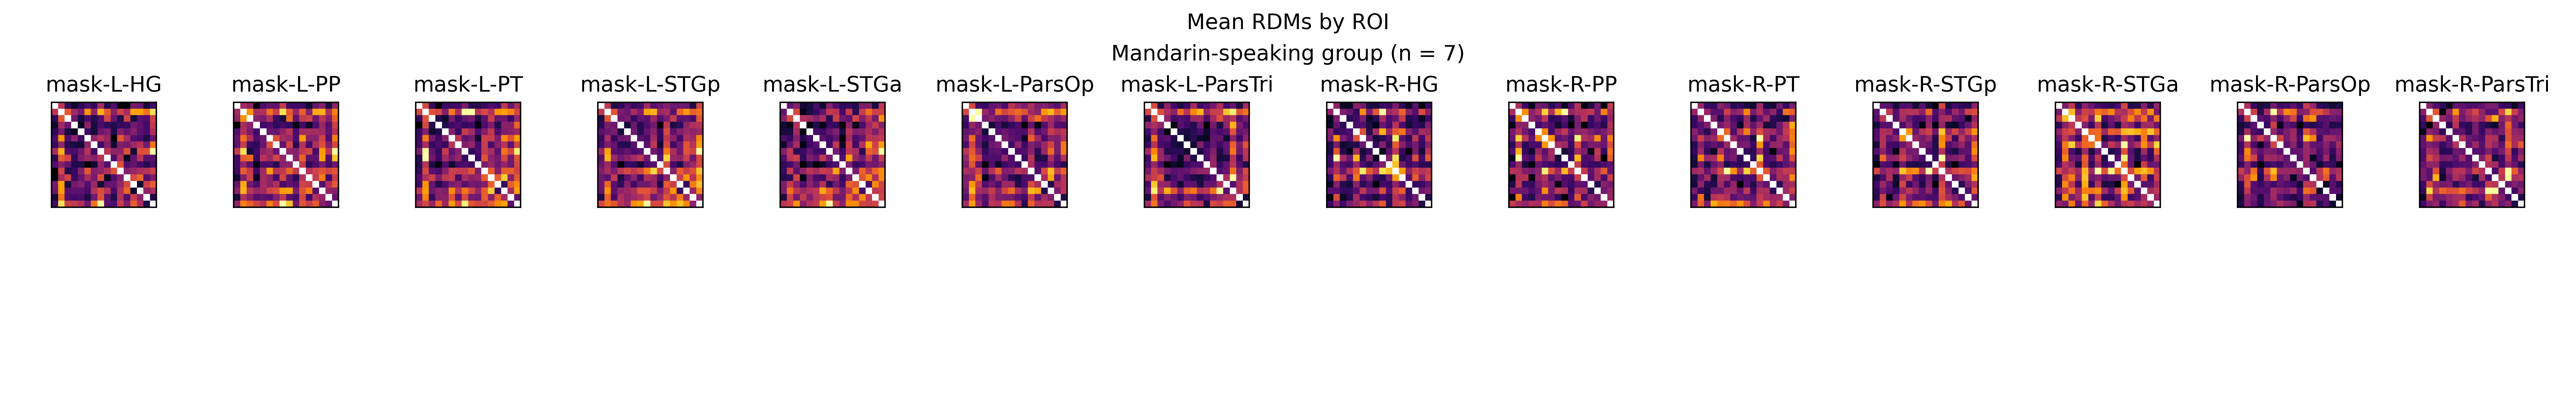

In [146]:
fig = plt.figure(constrained_layout=True, figsize=(20,3), dpi=500)
fig.suptitle('Mean RDMs by ROI')

#subfigs = fig.subfigures(nrows=1, ncols=1)
subfigs = fig.subfigures(nrows=2, ncols=1)

n_mand = len(participant_list)

subfigs[0].suptitle(f'Mandarin-speaking group (n = {n_mand})')

axs0 = subfigs[0].subplots(nrows=1, ncols=len(mask_list))
for rx, roi in enumerate(mask_list):
    rsatoolbox.vis.show_rdm_panel(mean_rdms.subset('ROI', value=roi), 
                                  rdm_descriptor='ROI', 
                                  cmap='inferno', 
                                  ax=axs0[rx])

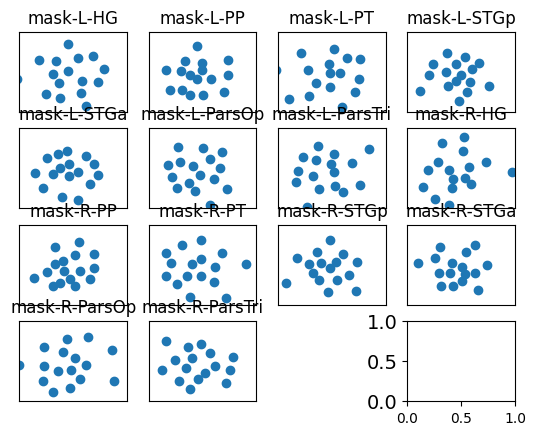

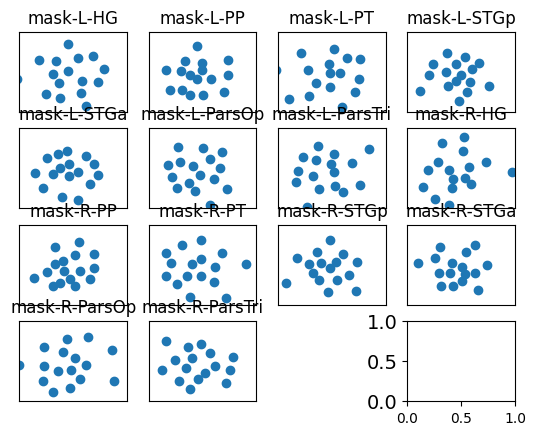

In [147]:
rsatoolbox.vis.scatter_plot.show_MDS(mean_rdms,
                                     rdm_descriptor='ROI',
                                     #pattern_descriptor='spect_mod_rate'
                                    )

### Stim model comparisons

(<Figure size 1250x1000 with 2 Axes>, <Axes: >, <Axes: >)

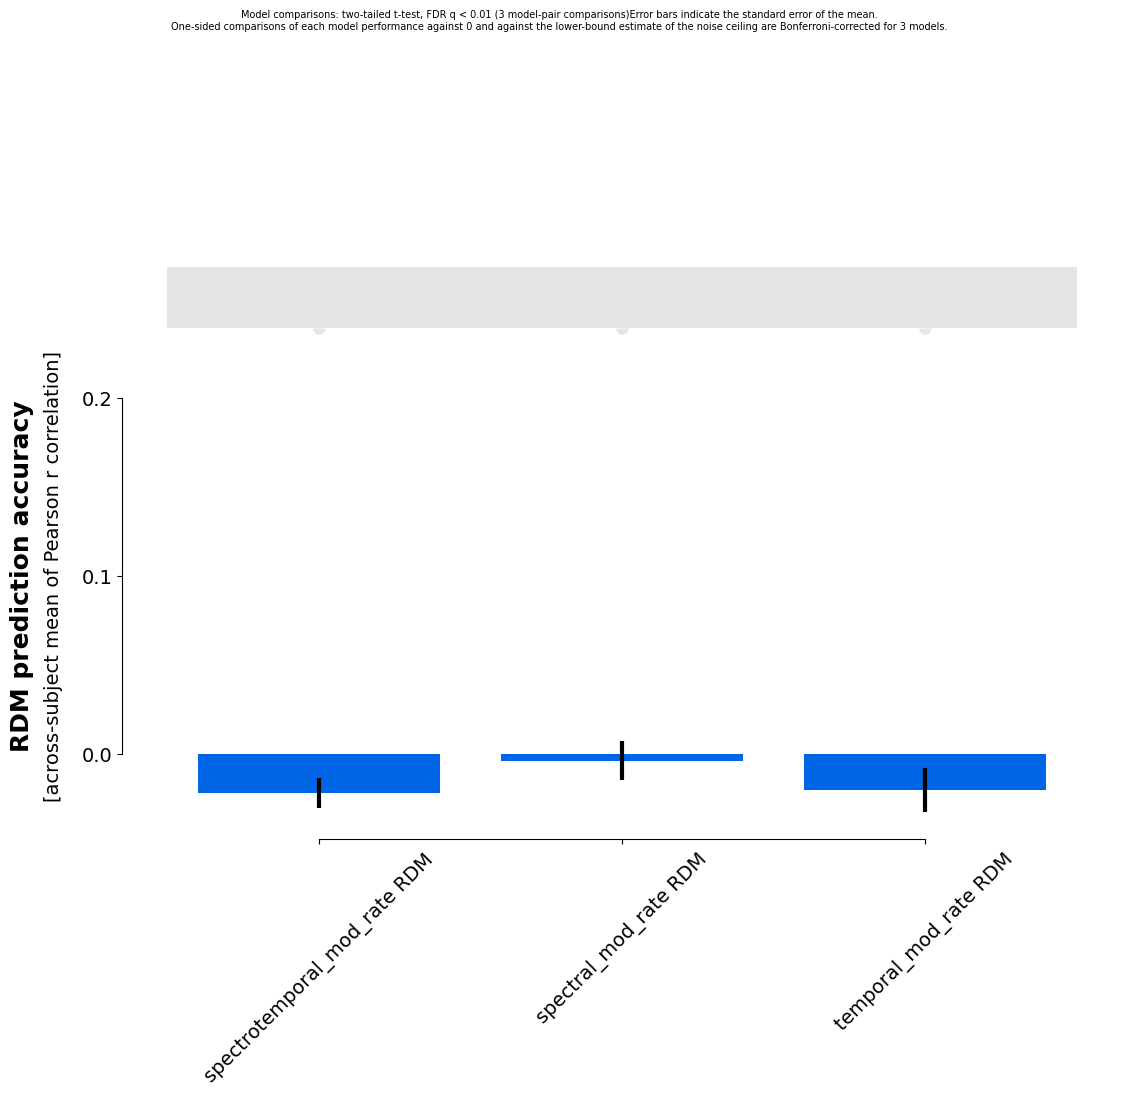

In [144]:
results_all = rsatoolbox.inference.eval_fixed(stim_models, 
                                              group_rdms,
                                              method='corr',)
rsatoolbox.vis.plot_model_comparison(results_all)

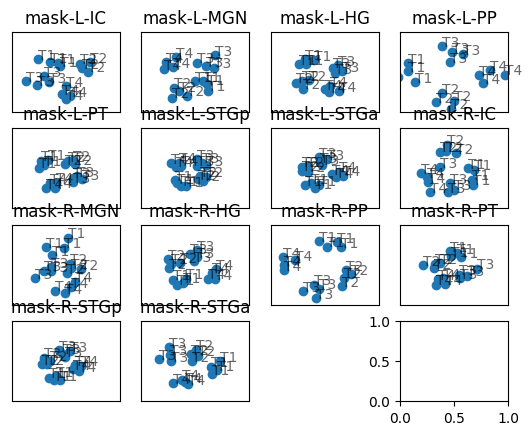

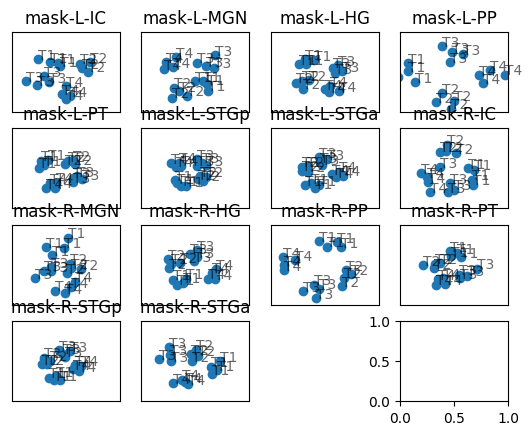

In [69]:
rsatoolbox.vis.scatter_plot.show_MDS(mean_rdms_mand, 
                                     rdm_descriptor='ROI',
                                     pattern_descriptor='tone')

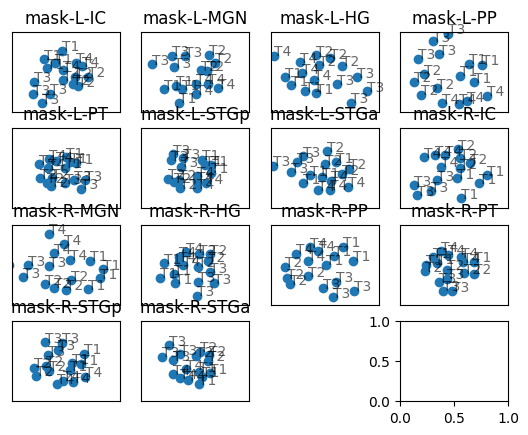

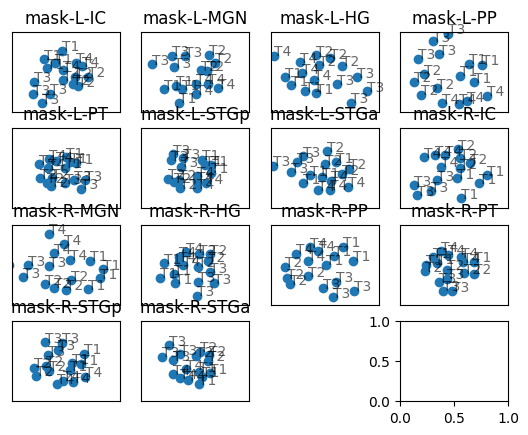

In [70]:
rsatoolbox.vis.scatter_plot.show_MDS(mean_rdms_nman, 
                                     rdm_descriptor='ROI',
                                     pattern_descriptor='tone')

<Figure size 640x480 with 0 Axes>

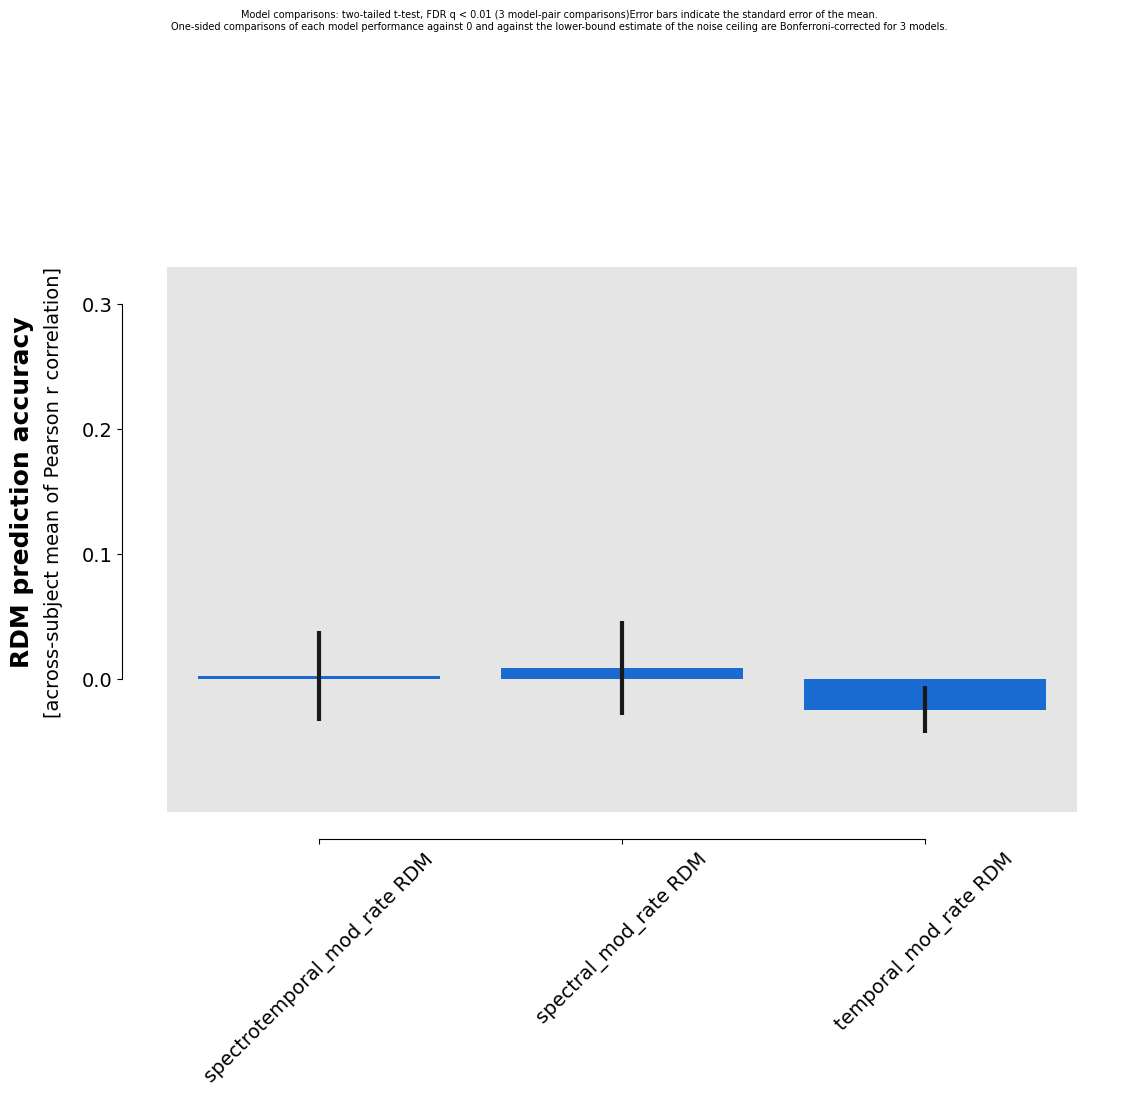

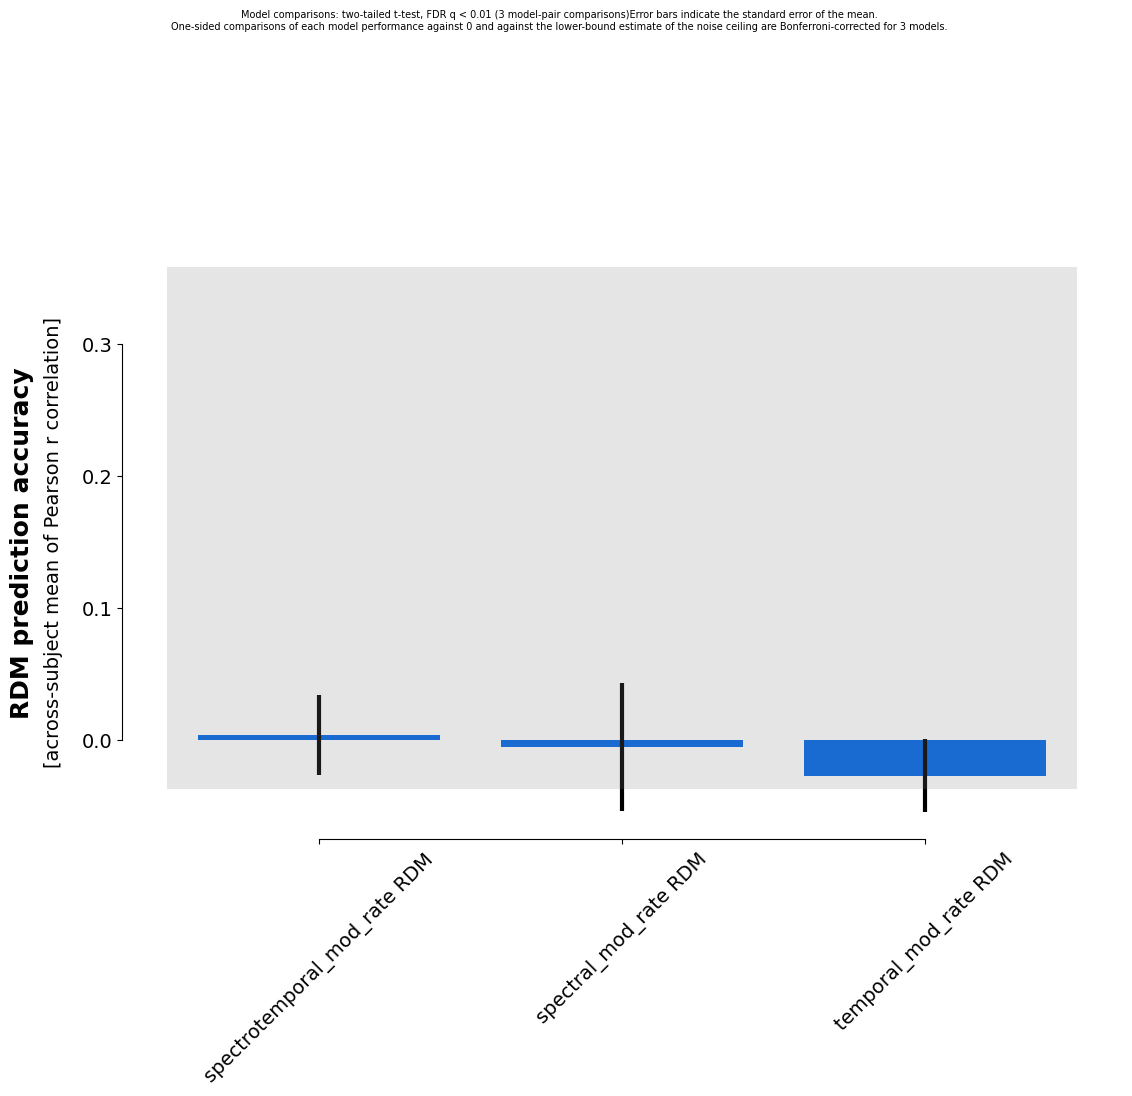

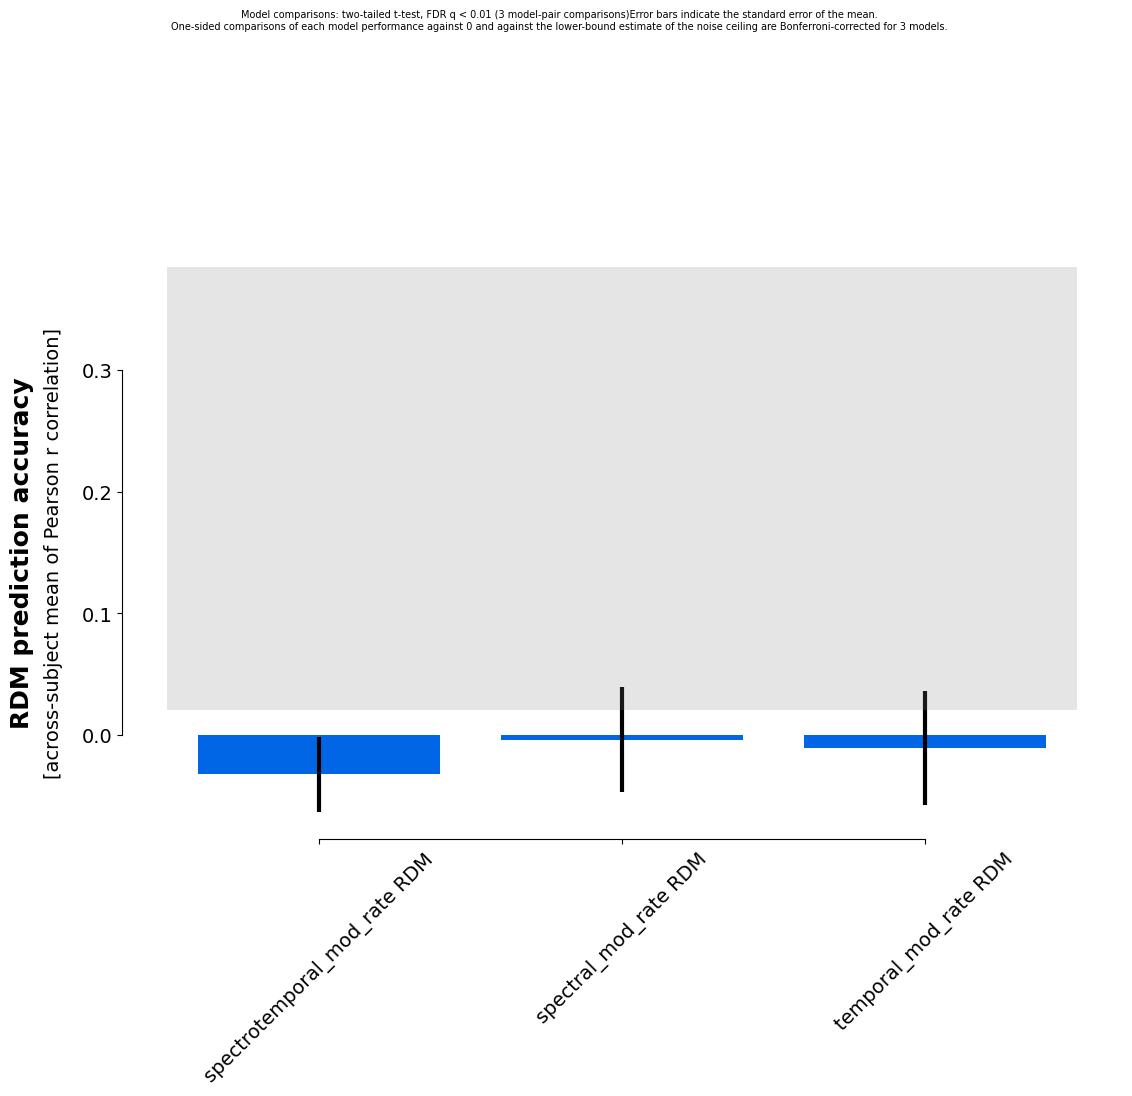

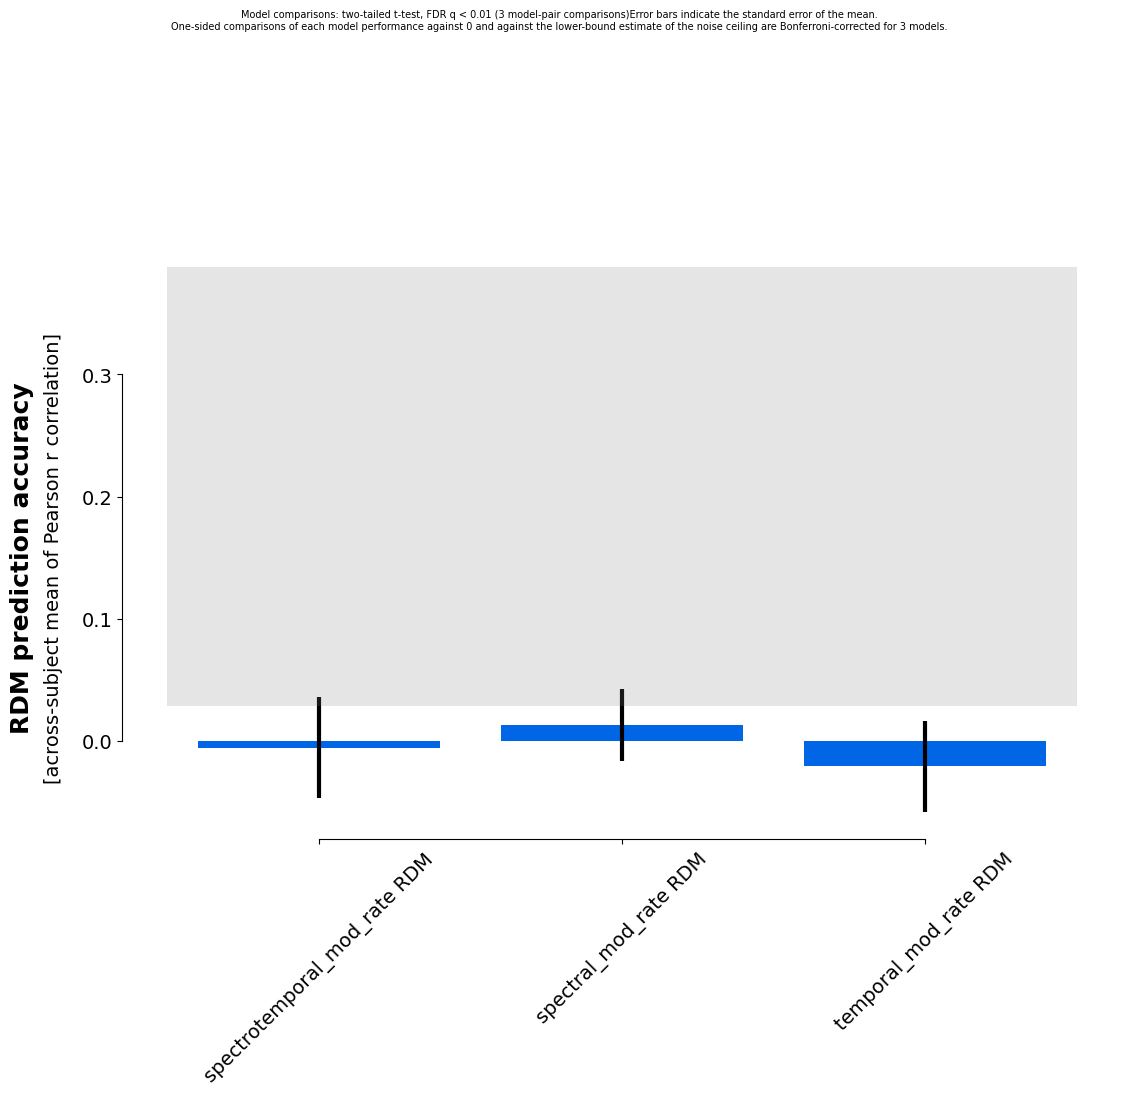

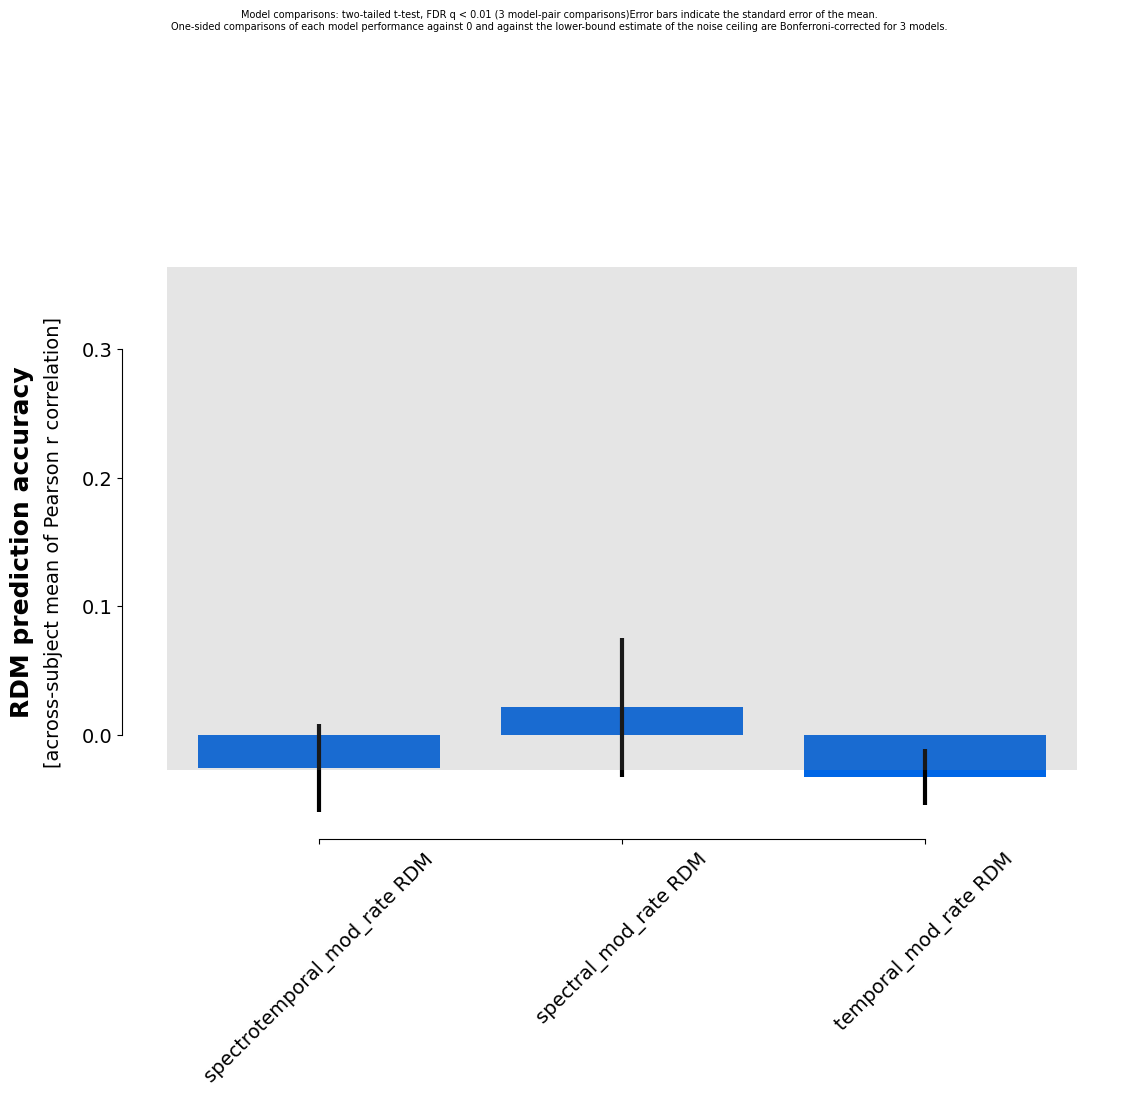

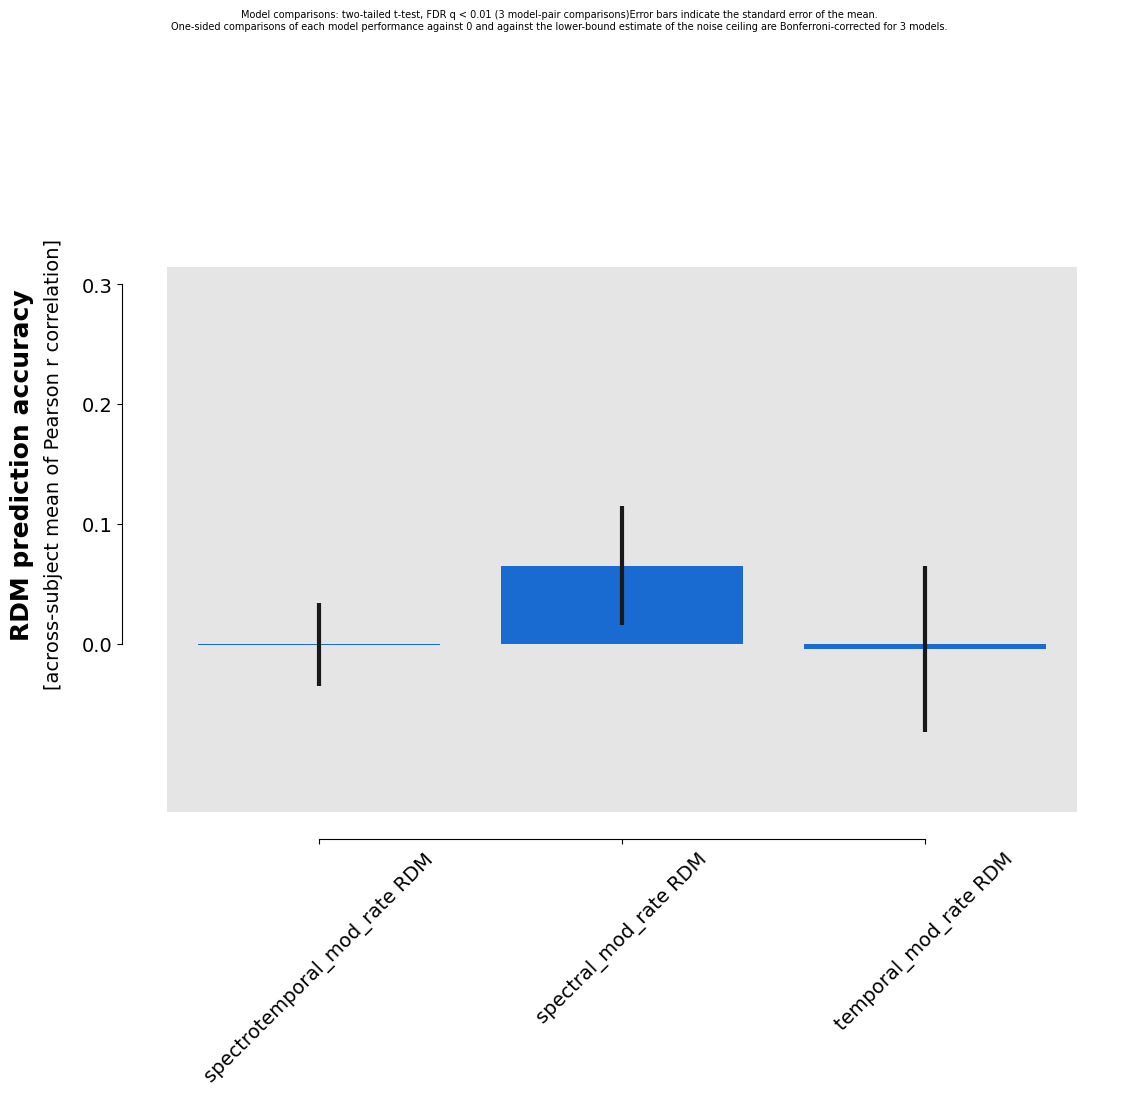

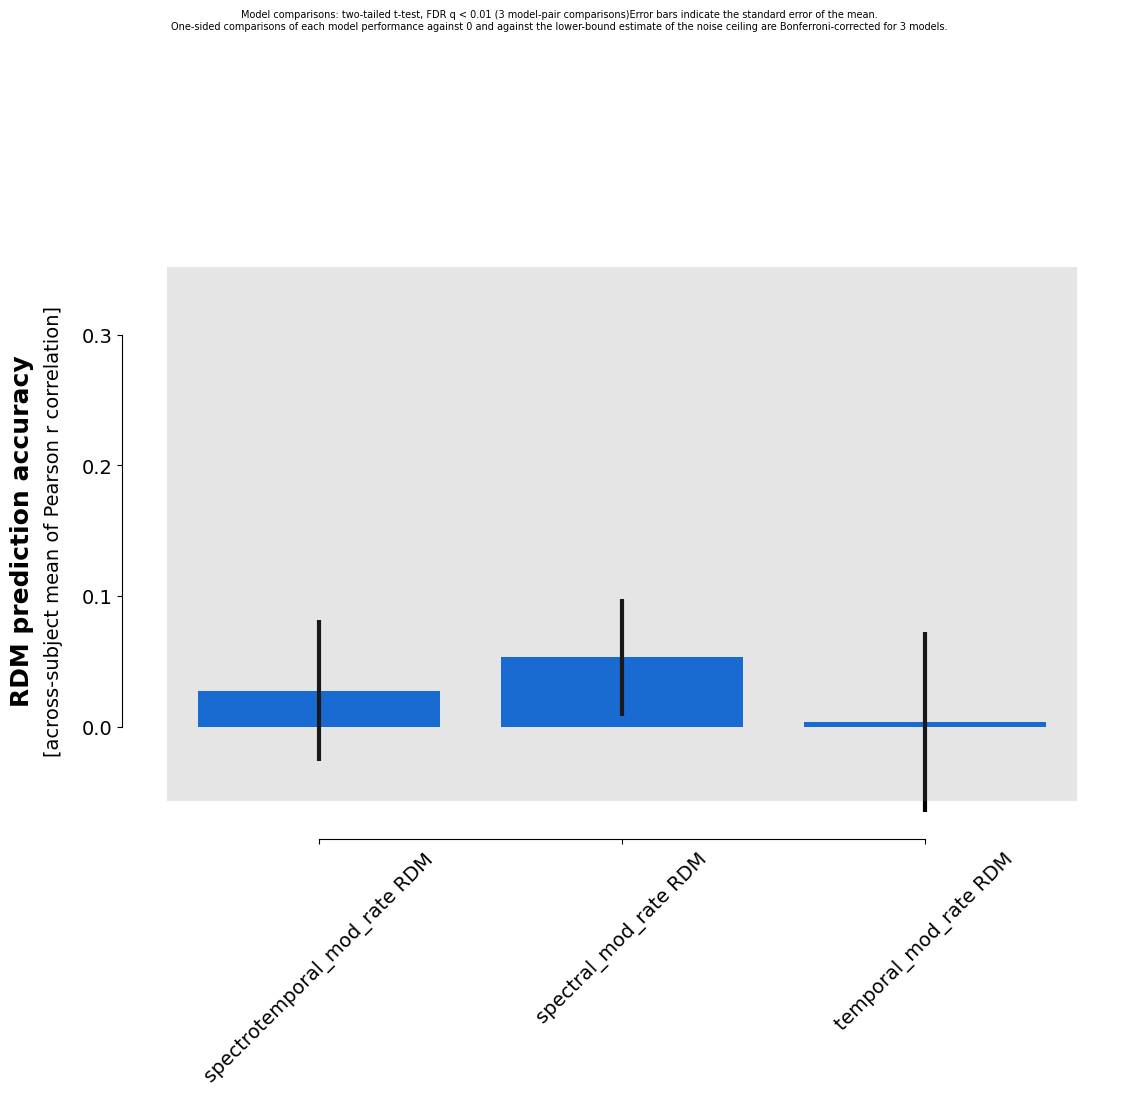

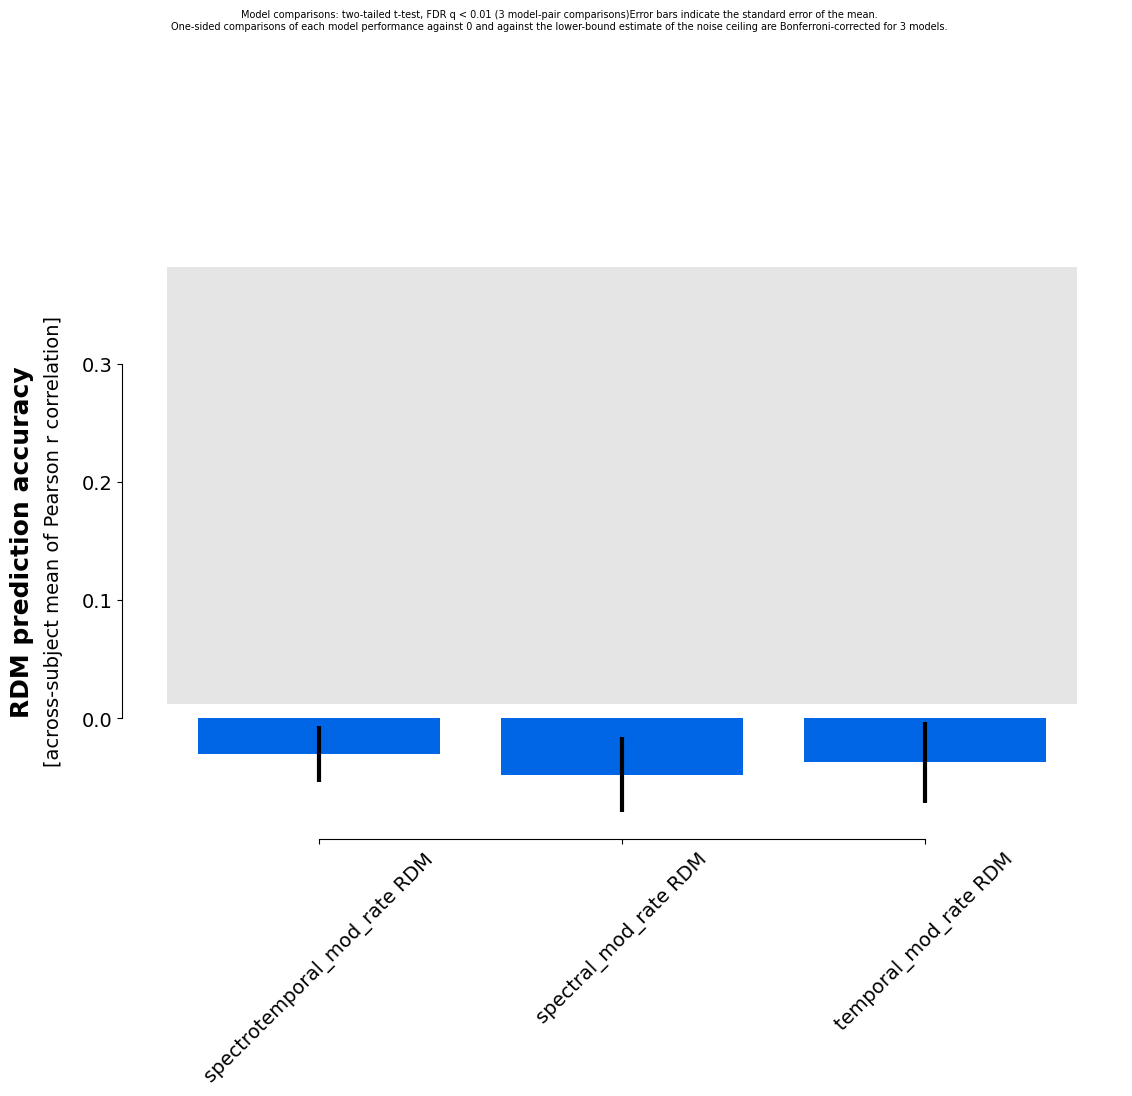

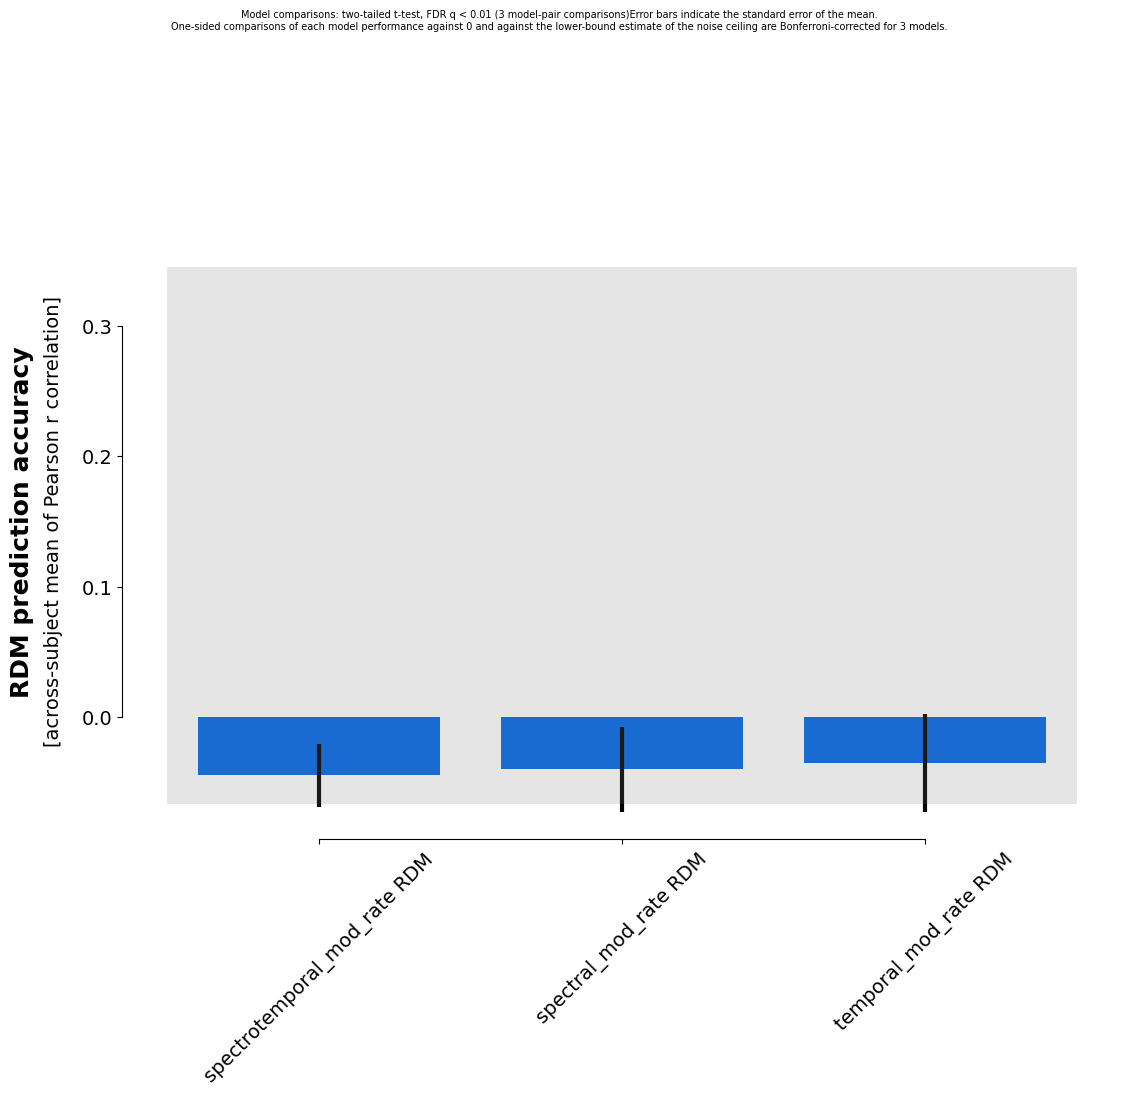

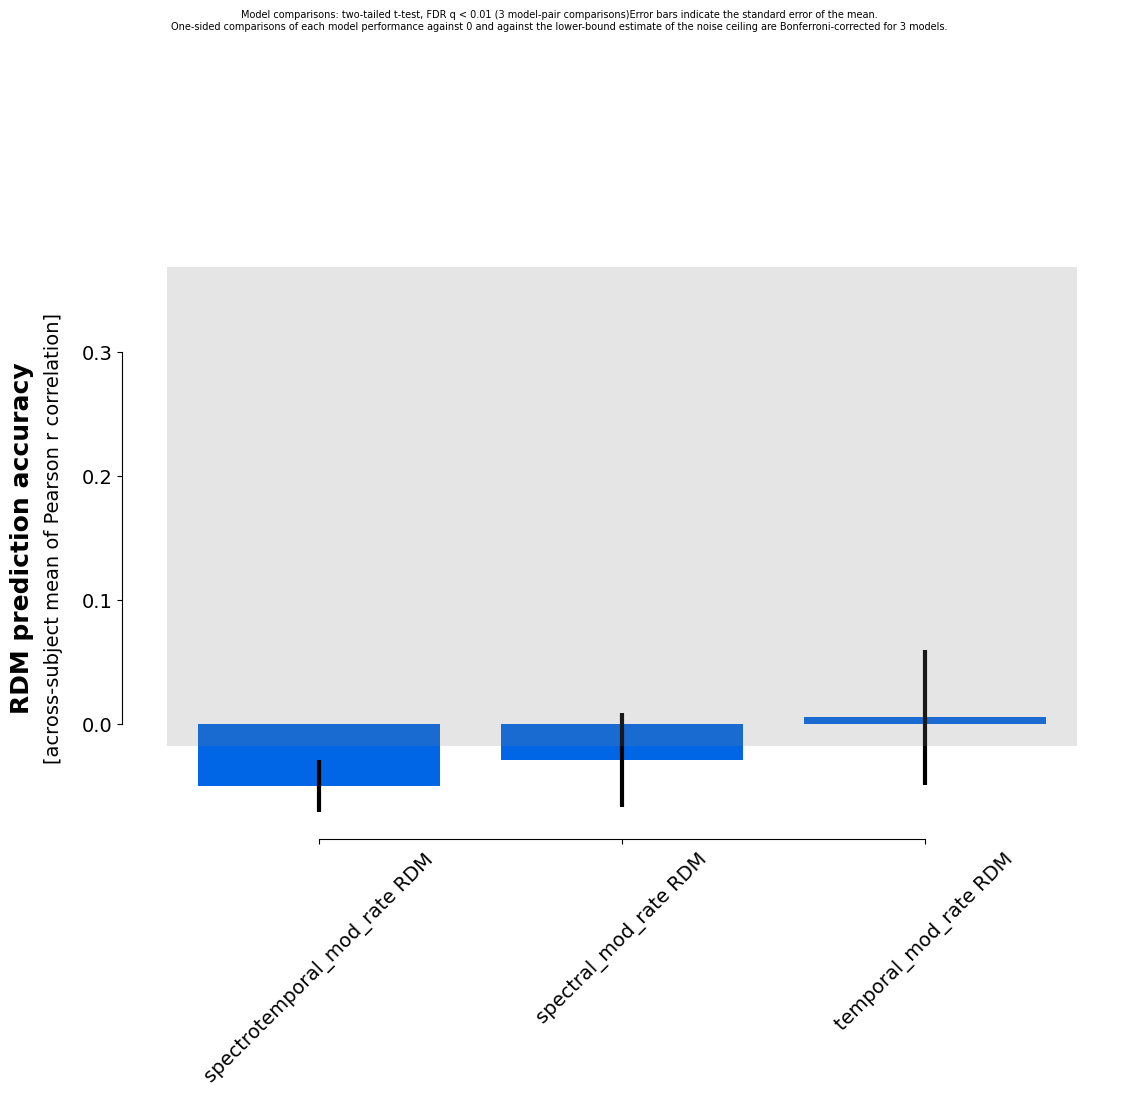

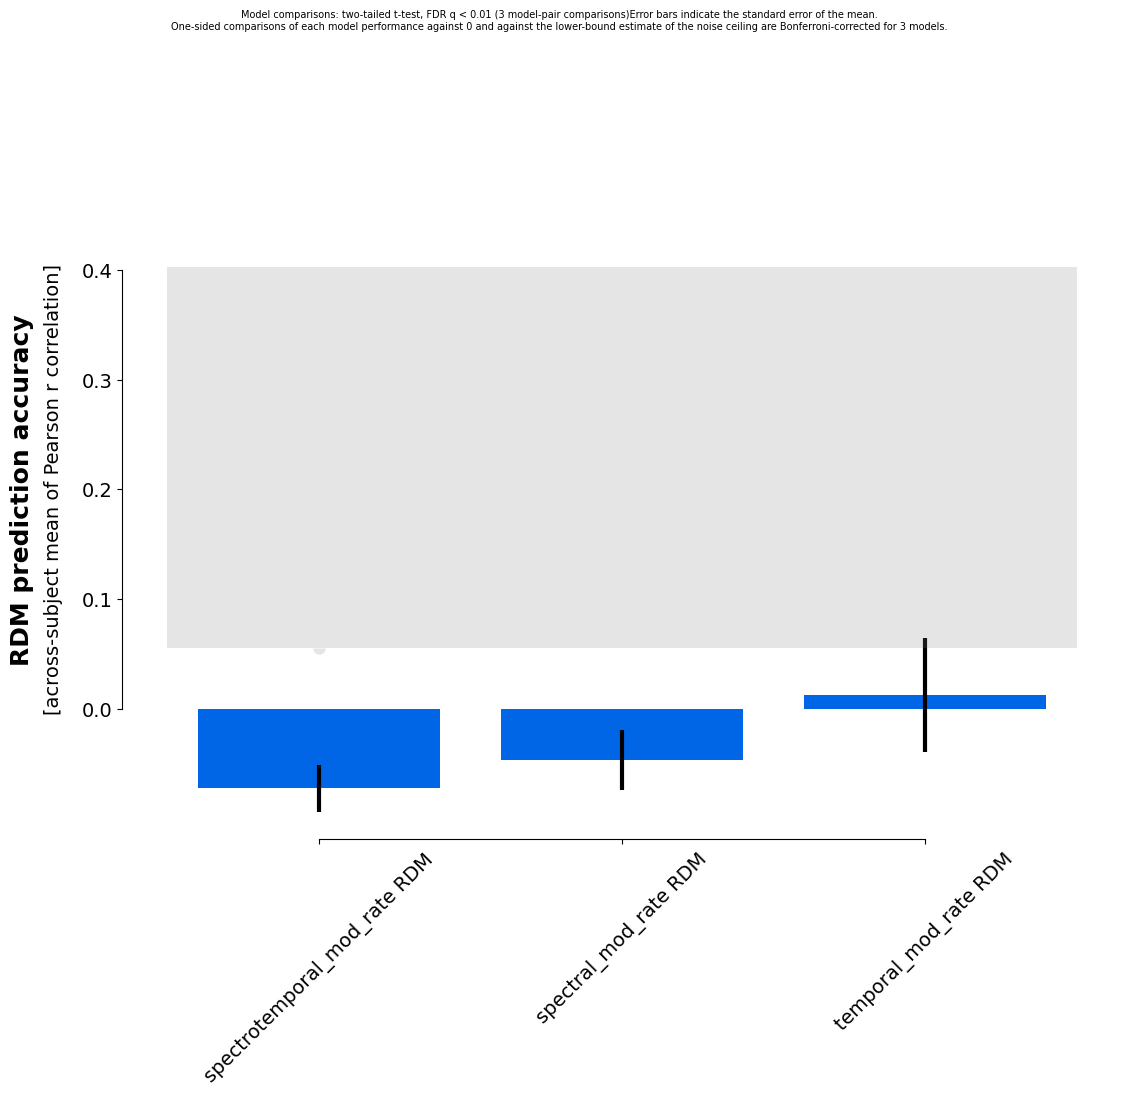

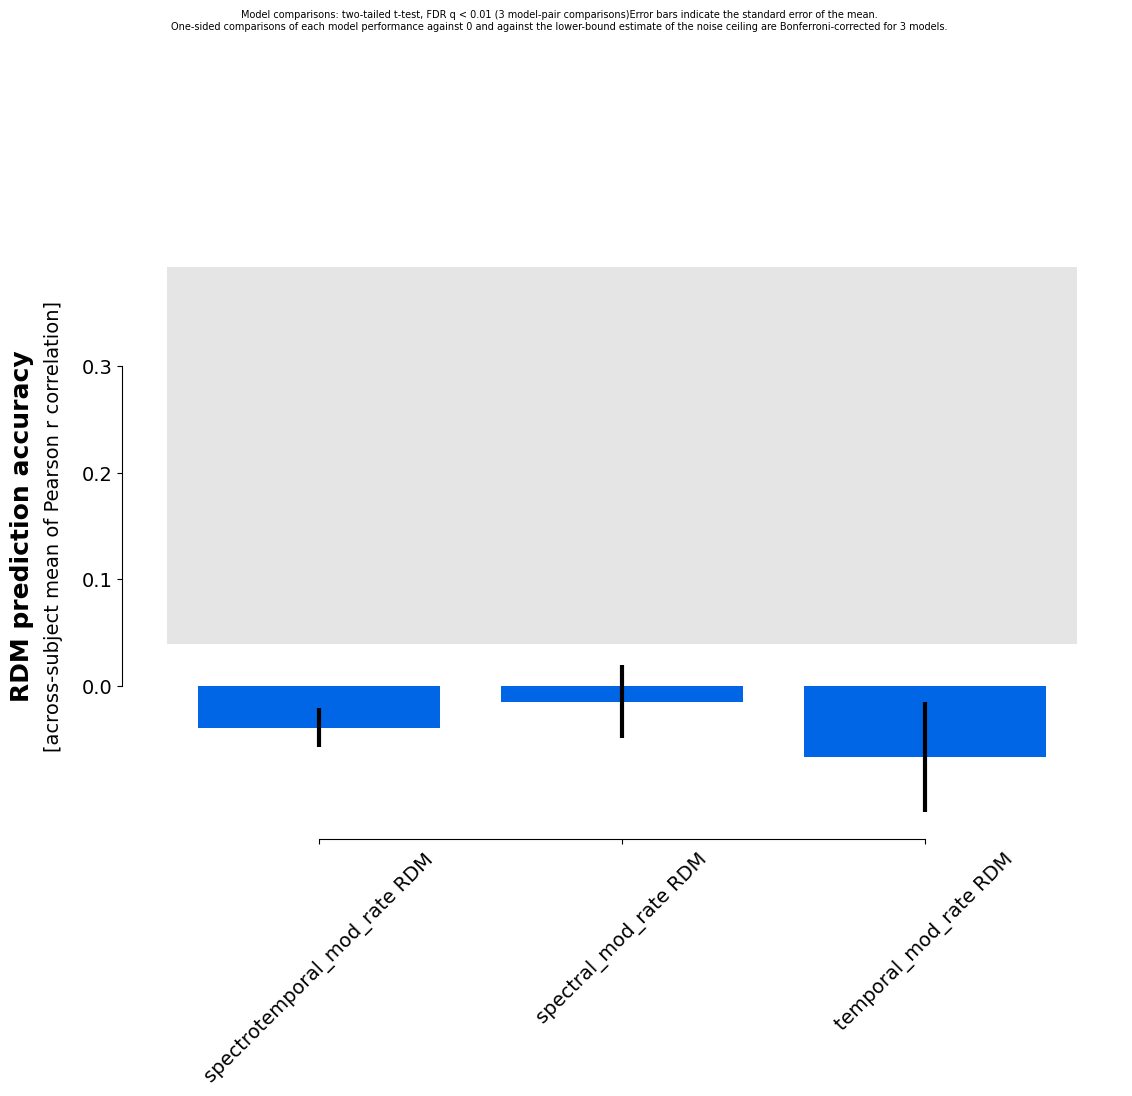

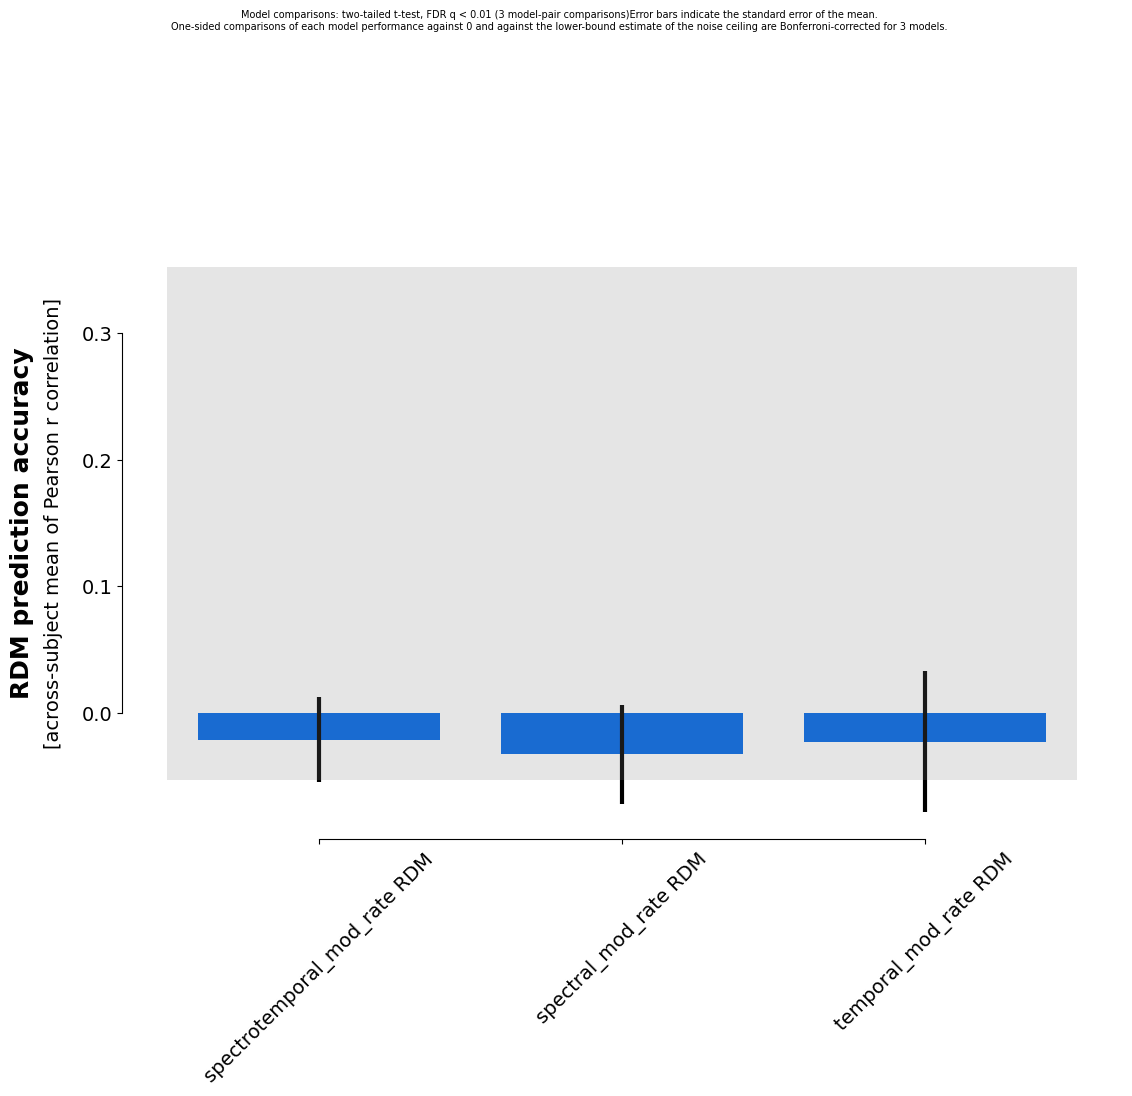

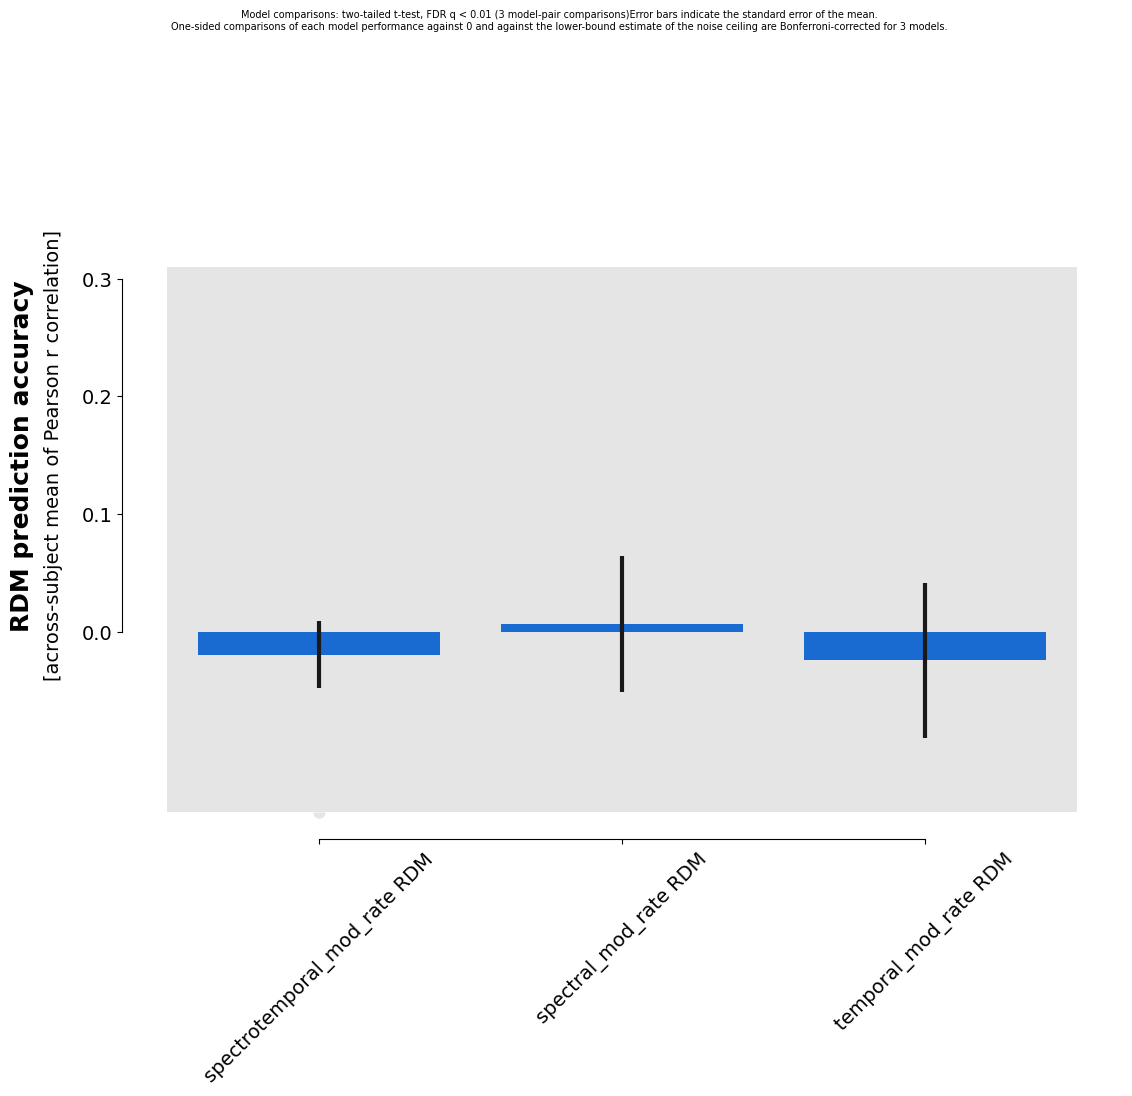

In [154]:
results_stim = []
fig = plt.figure()
for rx, roi in enumerate(mask_list):
    results_stim.append(rsatoolbox.inference.eval_fixed(stim_models, 
                                                     group_rdms.subset('ROI', value=roi), 
                                                     method='corr',))
    ax = rsatoolbox.vis.plot_model_comparison(results_stim[rx])
    #ax.set_title(roi)
    fig.axes.append(ax)

### Categorical model comparisons

In [33]:
results_1 = []
for roi in mask_list:
    print(roi)
    results_1.append(rsatoolbox.inference.eval_fixed(cat_models, 
                                                     group_rdms.subset('ROI', value=roi), 
                                                     method='corr',))


mask-L-IC
mask-L-MGN
mask-L-HG
mask-L-PP
mask-L-PT
mask-L-STGp
mask-L-STGa
mask-R-IC
mask-R-MGN
mask-R-HG
mask-R-PP
mask-R-PT
mask-R-STGp
mask-R-STGa


In [34]:
results_1[0].to_dict()

{'evaluations': array([[[ 0.37019978,  0.61820072,  0.39707351,  0.327332  ,
           0.37819262,  0.4266276 ,  0.51609843,  0.55533649,
           0.44143941,  0.57341444],
         [-0.12666414, -0.14907556, -0.08310437, -0.09684461,
          -0.14969841, -0.13437047, -0.11601775, -0.1523754 ,
          -0.11374368, -0.08369141]]]),
 'dof': 9,
 'variances': array([[ 9.76668131e-04, -5.93896909e-05],
        [-5.93896909e-05,  6.99347174e-05]]),
 'noise_ceiling': array([0.40951832, 0.55202638]),
 'method': 'corr',
 'cv_method': 'fixed',
 'models': {'model_0': {'rdm': {'dissimilarities': array([[0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
            0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
            1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
            1., 1., 1., 1.

In [1]:
for rx, roi in enumerate(mask_list):
    fig = rsatoolbox.vis.plot_model_comparison(results_1[roi])
    fig[0].suptitle(roi, fontsize=24)

NameError: name 'mask_list' is not defined

In [158]:
results_boot = rsatoolbox.inference.eval_dual_bootstrap(cat_models, group_rdms, rdm_descriptor='ROI')

100%|██████████| 1000/1000 [00:32<00:00, 30.37it/s]


(<Figure size 900x720 with 2 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fb2093294f0>)

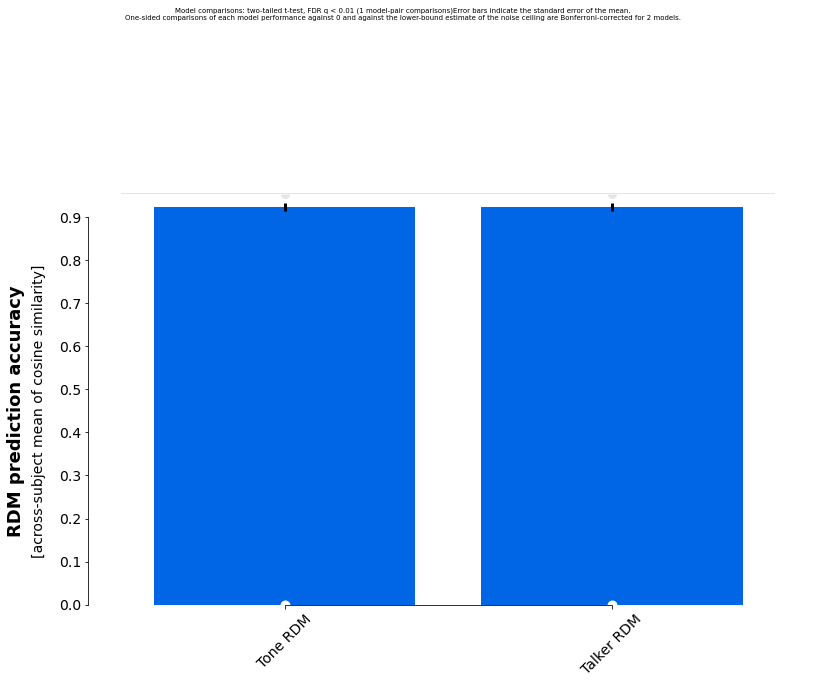

In [159]:
rsatoolbox.vis.plot_model_comparison(results_boot)